<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=f8657ae00e57586559fc533c2339a58653f3ca7fb2f8feac95f1d0c18a5995eb
  Stored in directory

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [7]:
sorted(val_df.label.unique())

[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]

In [8]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}

In [9]:
# Different combinations to evaluate
models = [CustomResNet50, CustomResNet50b, CustomDenseNet]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]
loaders = ['dataloaders', 'dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2}
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 393MB/s]


Epoch 0/14
----------
train Loss: 1.9791 Acc: 0.4317
val Loss: 1.3012 Acc: 0.6469

Epoch 1/14
----------
train Loss: 0.9450 Acc: 0.7502
val Loss: 0.8980 Acc: 0.7288

Epoch 2/14
----------
train Loss: 0.5800 Acc: 0.8378
val Loss: 0.7253 Acc: 0.7853

Epoch 3/14
----------
train Loss: 0.3690 Acc: 0.8955
val Loss: 0.6654 Acc: 0.7825

Epoch 4/14
----------
train Loss: 0.2714 Acc: 0.9372
val Loss: 0.6775 Acc: 0.7797

Epoch 5/14
----------
train Loss: 0.1744 Acc: 0.9679
val Loss: 0.6282 Acc: 0.8136

Epoch 6/14
----------
train Loss: 0.1154 Acc: 0.9795
val Loss: 0.6433 Acc: 0.8136

Epoch 7/14
----------
train Loss: 0.0949 Acc: 0.9876
val Loss: 0.6500 Acc: 0.8051

Epoch 8/14
----------
train Loss: 0.0735 Acc: 0.9912
val Loss: 0.6159 Acc: 0.8164

Epoch 9/14
----------
train Loss: 0.0810 Acc: 0.9898
val Loss: 0.6350 Acc: 0.8107

Epoch 10/14
----------
train Loss: 0.0742 Acc: 0.9927
val Loss: 0.6284 Acc: 0.8136

Epoch 11/14
----------
train Loss: 0.0675 Acc: 0.9927
val Loss: 0.6270 Acc: 0.8107

Ep

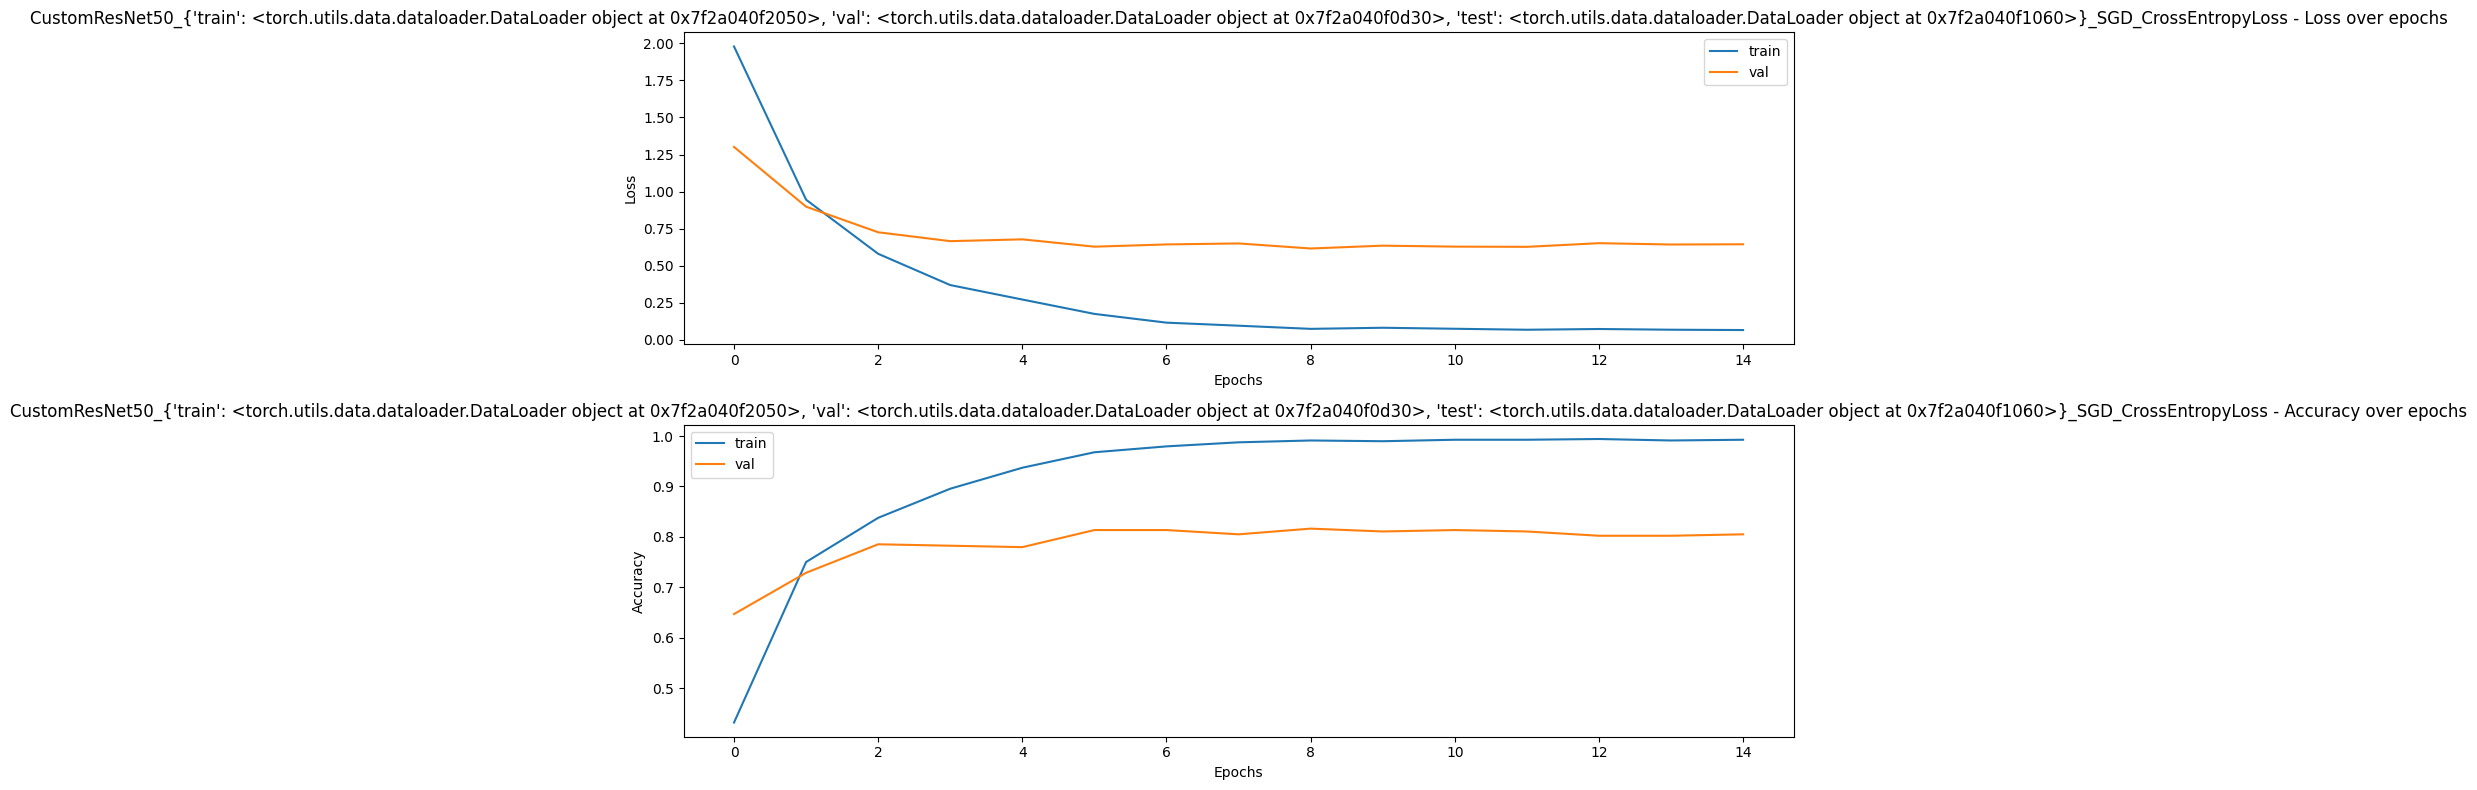


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5185 Acc: 0.4259
val Loss: 0.8509 Acc: 0.6469

Epoch 1/14
----------
train Loss: 0.5097 Acc: 0.7670
val Loss: 0.5224 Acc: 0.7542

Epoch 2/14
----------
train Loss: 0.2733 Acc: 0.8619
val Loss: 0.4378 Acc: 0.7881

Epoch 3/14
----------
train Loss: 0.1607 Acc: 0.9270
val Loss: 0.4578 Acc: 0.7881

Epoch 4/14
----------
train Loss: 0.1013 Acc: 0.9481
val Loss: 0.3738 Acc: 0.8136

Epoch 5/14
----------
train Loss: 0.0623 Acc: 0.9774
val Loss: 0.3706 Acc: 0.8107

Epoch 6/14
----------
train Loss: 0.0378 Acc: 0.9890
val Loss: 0.4058 Acc: 0.8023

Epoch 7/14
----------
train Loss: 0.0325 Acc: 0.9927
val Loss: 0.3889 Acc: 0.7994

Epoch 8/14
----------
train Loss: 0.0301 Acc: 0.9949
val Loss: 

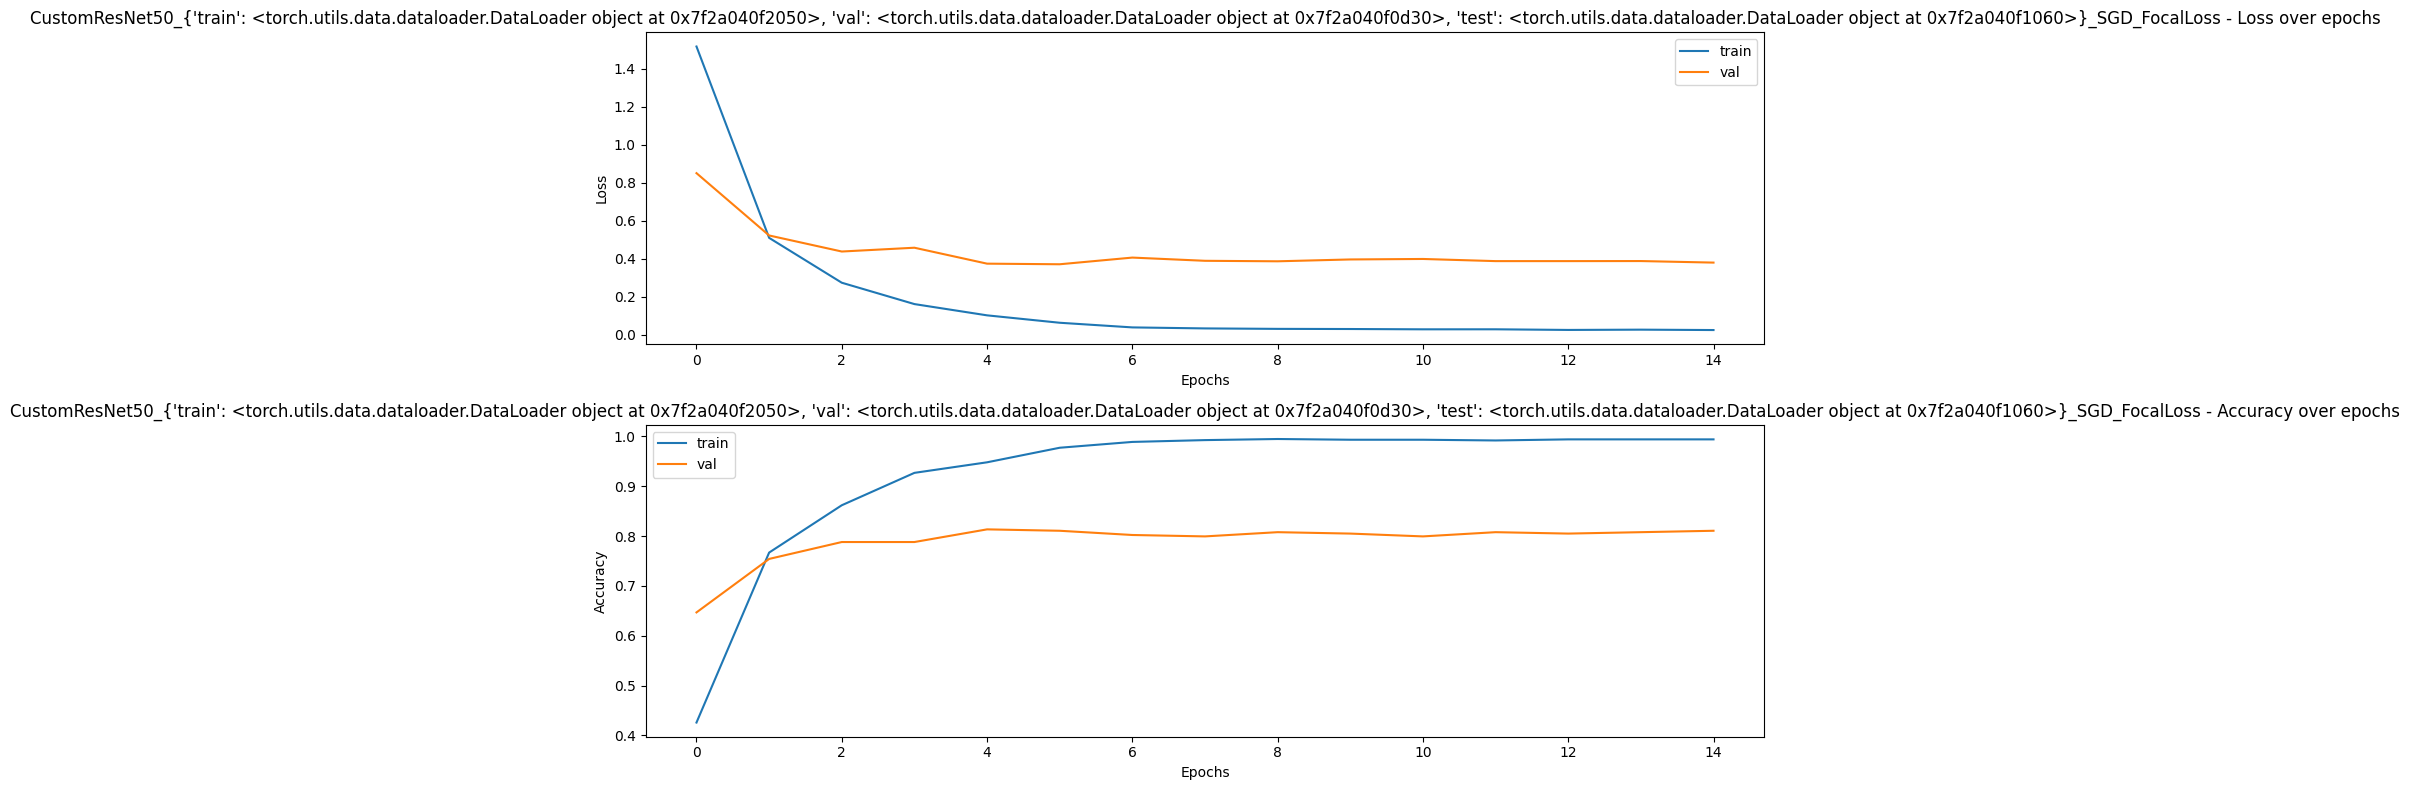


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9258 Acc: 0.3696
val Loss: 2.1834 Acc: 0.3249

Epoch 1/14
----------
train Loss: 1.3533 Acc: 0.5471
val Loss: 2.3321 Acc: 0.3983

Epoch 2/14
----------
train Loss: 1.1086 Acc: 0.6209
val Loss: 1.8947 Acc: 0.4209

Epoch 3/14
----------
train Loss: 1.0343 Acc: 0.6406
val Loss: 2.2739 Acc: 0.5000

Epoch 4/14
----------
train Loss: 0.8425 Acc: 0.7137
val Loss: 1.3291 Acc: 0.6017

Epoch 5/14
----------
train Loss: 0.8126 Acc: 0.7129
val Loss: 1.5500 Acc: 0.5254

Epoch 6/14
----------
train Loss: 0.6864 Acc: 0.7684
val Loss: 1.0985 Acc: 0.6667

Epoch 7/14
----------
train Loss: 0.4337 Acc: 0.8539
val Loss: 0.6180 Acc: 0.7768

Epoch 8/14
----------
train Loss: 0.3529 Acc: 0.8904
va

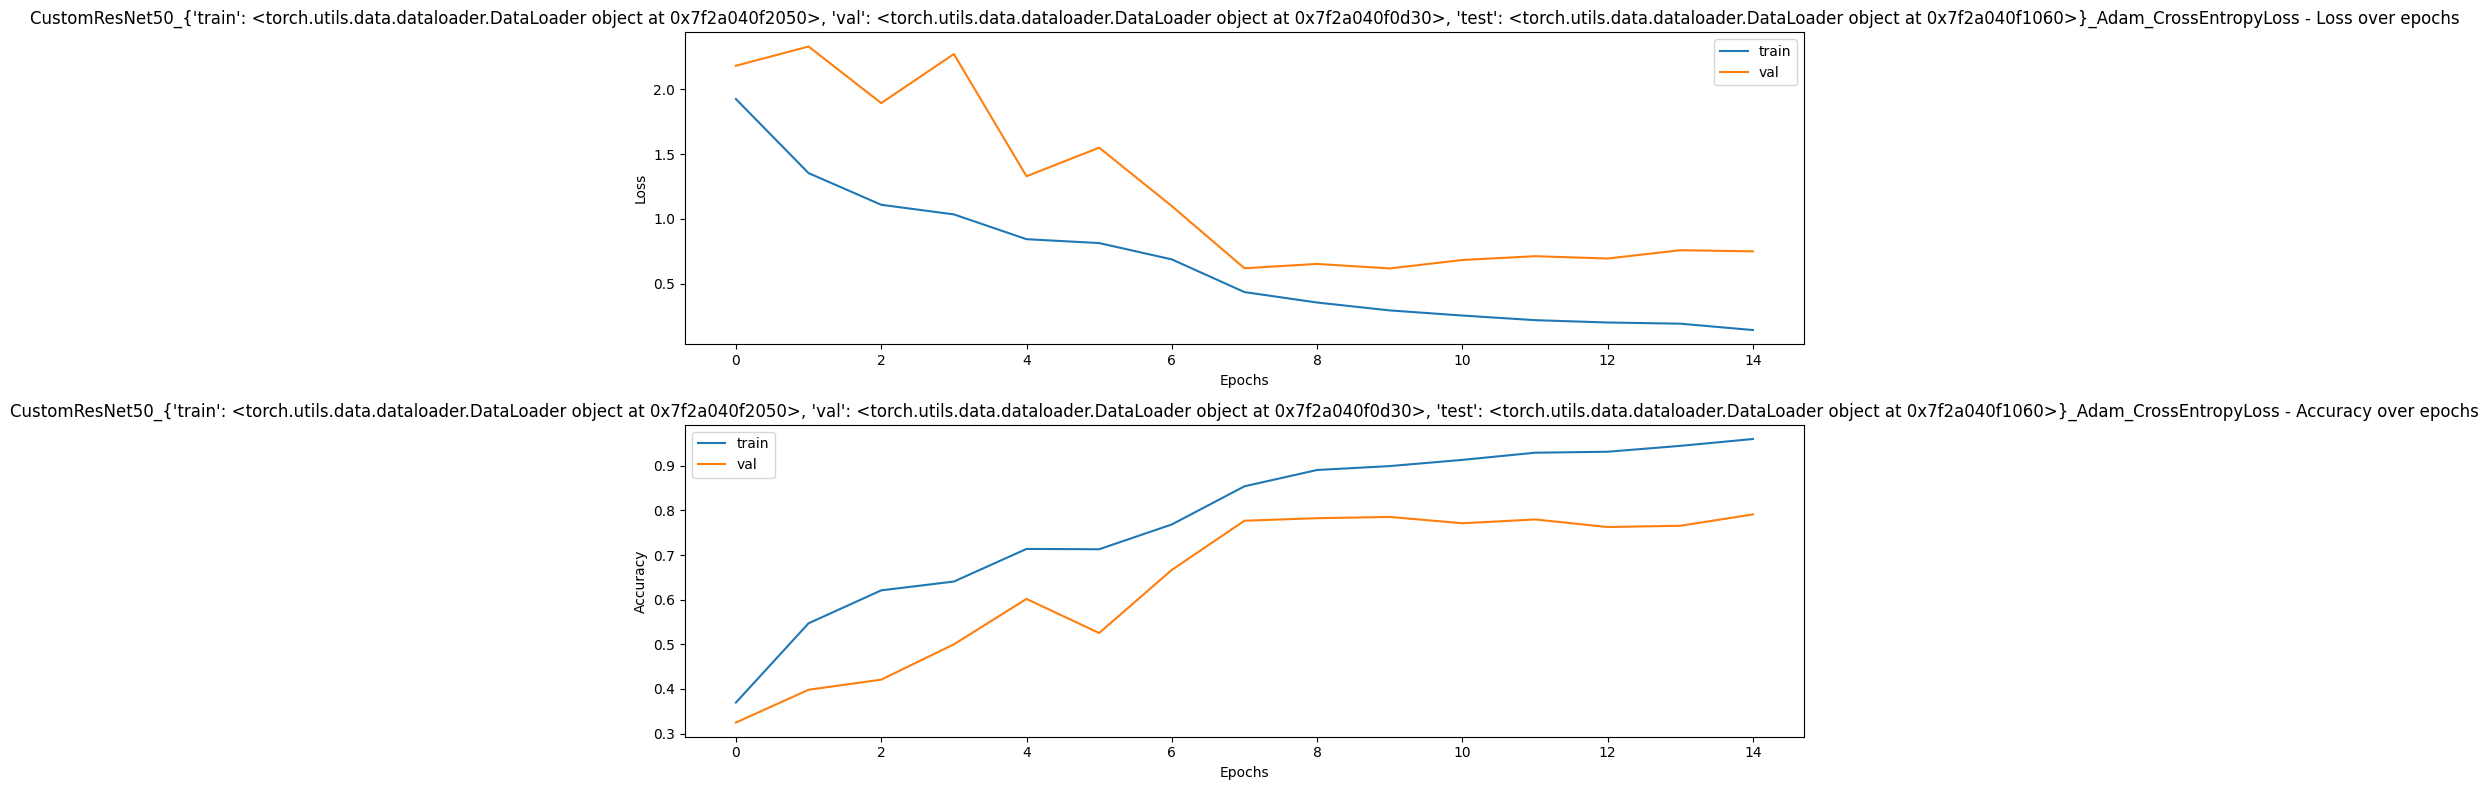


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.2931 Acc: 0.4551
val Loss: 1.2758 Acc: 0.4350

Epoch 1/14
----------
train Loss: 0.8395 Acc: 0.5888
val Loss: 1.0747 Acc: 0.5339

Epoch 2/14
----------
train Loss: 0.6432 Acc: 0.6698
val Loss: 1.4042 Acc: 0.4887

Epoch 3/14
----------
train Loss: 0.5905 Acc: 0.6815
val Loss: 1.0927 Acc: 0.5650

Epoch 4/14
----------
train Loss: 0.4459 Acc: 0.7451
val Loss: 0.9808 Acc: 0.6017

Epoch 5/14
----------
train Loss: 0.3384 Acc: 0.7874
val Loss: 0.6520 Acc: 0.7090

Epoch 6/14
----------
train Loss: 0.4263 Acc: 0.7604
val Loss: 0.9663 Acc: 0.5904

Epoch 7/14
----------
train Loss: 0.2092 Acc: 0.8700
val Loss: 0.4262 Acc: 0.7571

Epoch 8/14
----------
train Loss: 0.1364 Acc: 0.9007
val Loss:

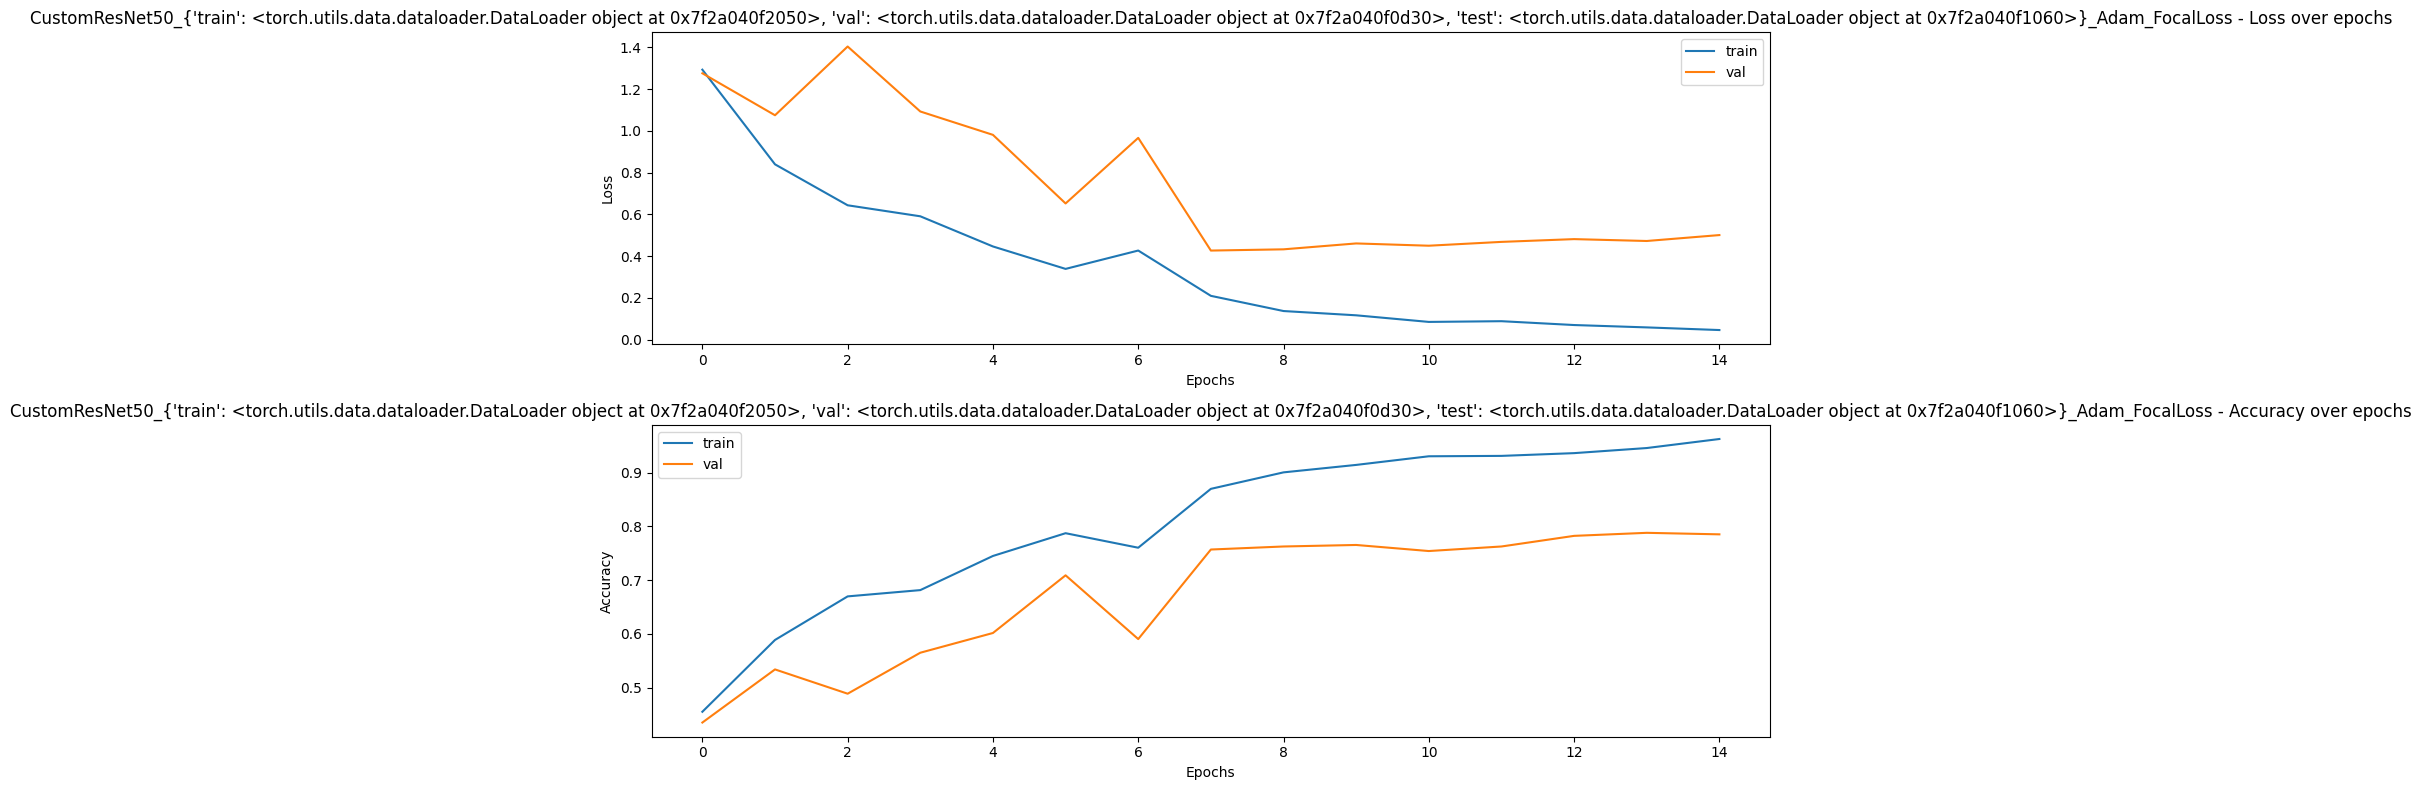


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0935 Acc: 0.3660
val Loss: 1.4056 Acc: 0.5706

Epoch 1/14
----------
train Loss: 1.0416 Acc: 0.7071
val Loss: 0.9068 Acc: 0.7062

Epoch 2/14
----------
train Loss: 0.6888 Acc: 0.7889
val Loss: 0.7349 Acc: 0.7853

Epoch 3/14
----------
train Loss: 0.4640 Acc: 0.8678
val Loss: 0.6534 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.3503 Acc: 0.8992
val Loss: 0.6208 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.2621 Acc: 0.9313
val Loss: 0.5826 Acc: 0.8192

Epoch 6/14
----------
train Loss: 0.2004 Acc: 0.9562
val Loss: 0.6245 Acc: 0.8079

Epoch 7/14
----------
train Loss: 0.1494 Acc: 0.9657
val Loss: 0.5820 Acc: 0.8051

Epoch 8/14
----------
train Loss: 0.1283 Acc: 0.9737
val

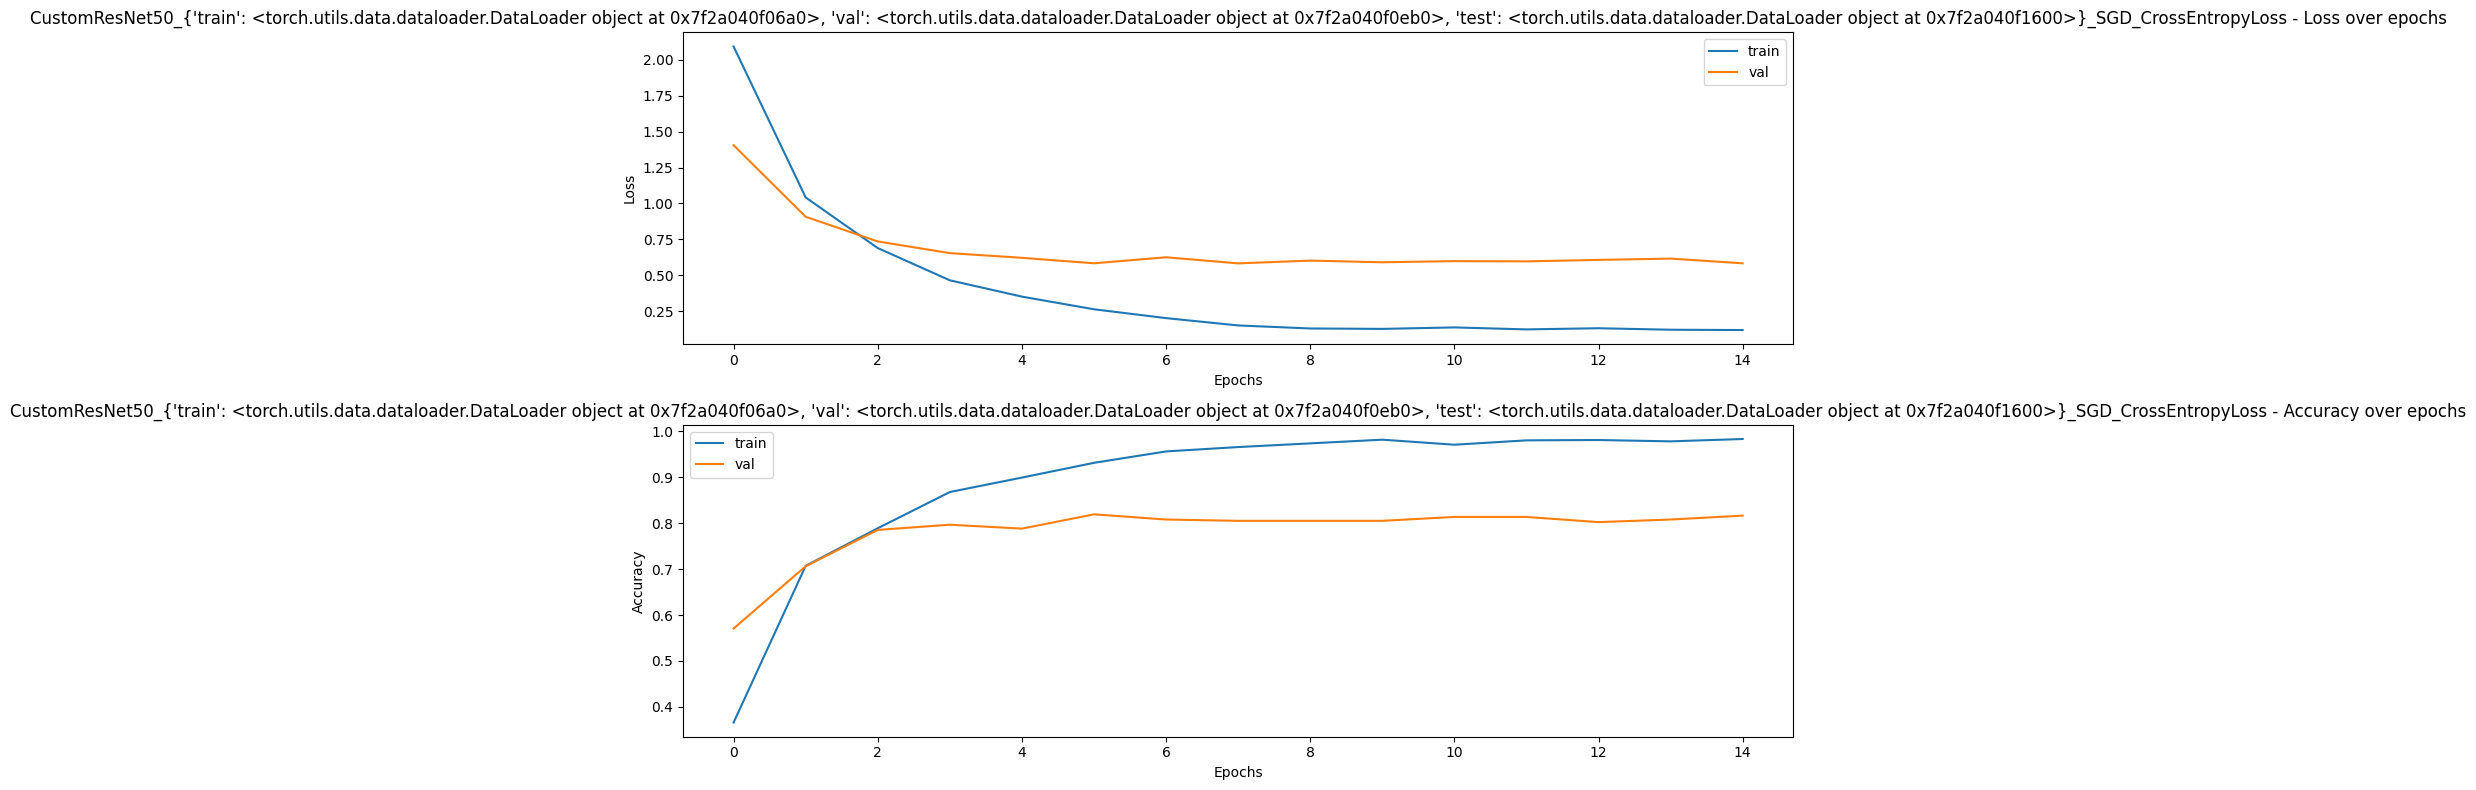


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5422 Acc: 0.4237
val Loss: 0.8527 Acc: 0.6158

Epoch 1/14
----------
train Loss: 0.5932 Acc: 0.7392
val Loss: 0.6135 Acc: 0.7006

Epoch 2/14
----------
train Loss: 0.3690 Acc: 0.8188
val Loss: 0.4795 Acc: 0.7599

Epoch 3/14
----------
train Loss: 0.2308 Acc: 0.8736
val Loss: 0.4232 Acc: 0.7853

Epoch 4/14
----------
train Loss: 0.1715 Acc: 0.9050
val Loss: 0.4020 Acc: 0.8023

Epoch 5/14
----------
train Loss: 0.1101 Acc: 0.9401
val Loss: 0.3879 Acc: 0.8051

Epoch 6/14
----------
train Loss: 0.0933 Acc: 0.9481
val Loss: 0.3757 Acc: 0.8164

Epoch 7/14
----------
train Loss: 0.0680 Acc: 0.9657
val Loss: 0.3644 Acc: 0.8249

Epoch 8/14
----------
train Loss: 0.0549 Acc: 0.9788
val Loss: 

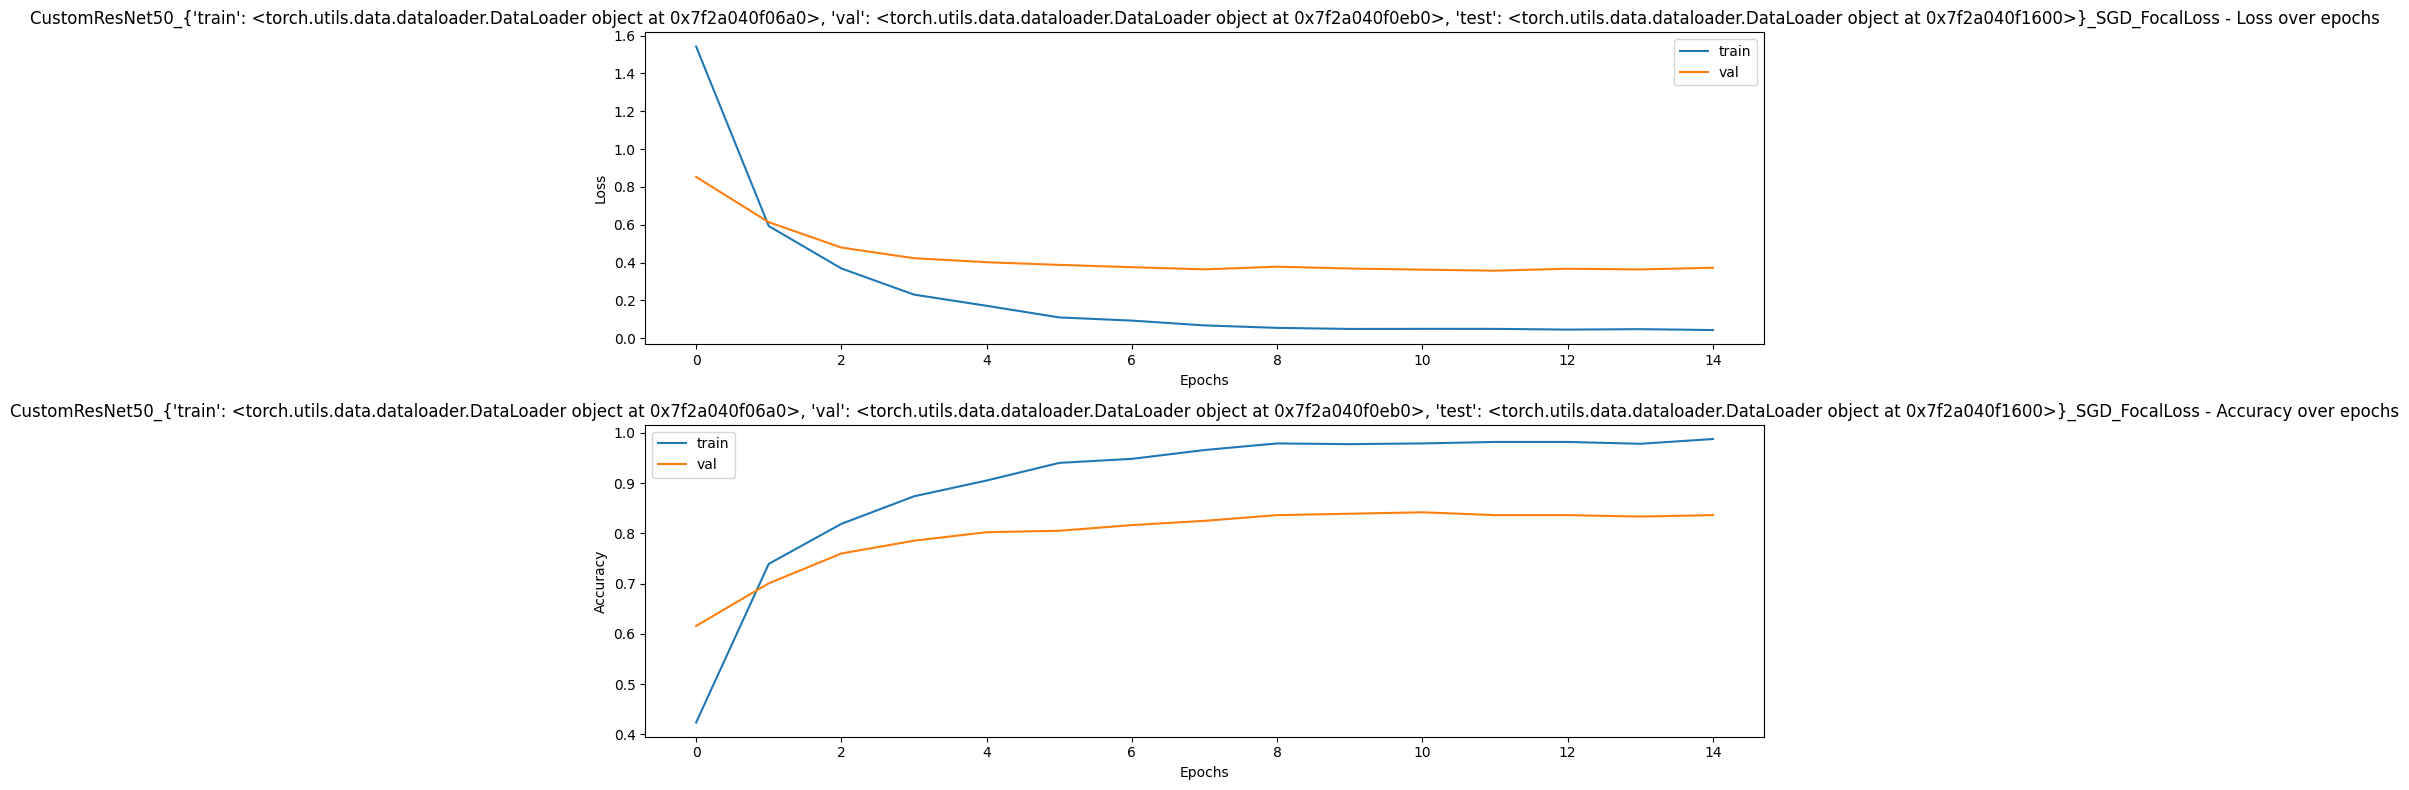


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9213 Acc: 0.3988
val Loss: 4.9187 Acc: 0.3051

Epoch 1/14
----------
train Loss: 1.5138 Acc: 0.5113
val Loss: 1.5654 Acc: 0.4859

Epoch 2/14
----------
train Loss: 1.1818 Acc: 0.6121
val Loss: 1.5373 Acc: 0.5282

Epoch 3/14
----------
train Loss: 1.0412 Acc: 0.6574
val Loss: 1.2271 Acc: 0.5791

Epoch 4/14
----------
train Loss: 0.9182 Acc: 0.6757
val Loss: 1.9616 Acc: 0.4689

Epoch 5/14
----------
train Loss: 0.8371 Acc: 0.7093
val Loss: 1.3332 Acc: 0.6186

Epoch 6/14
----------
train Loss: 0.7482 Acc: 0.7502
val Loss: 1.6753 Acc: 0.6186

Epoch 7/14
----------
train Loss: 0.5166 Acc: 0.8283
val Loss: 0.8041 Acc: 0.7175

Epoch 8/14
----------
train Loss: 0.3975 Acc: 0.8707
va

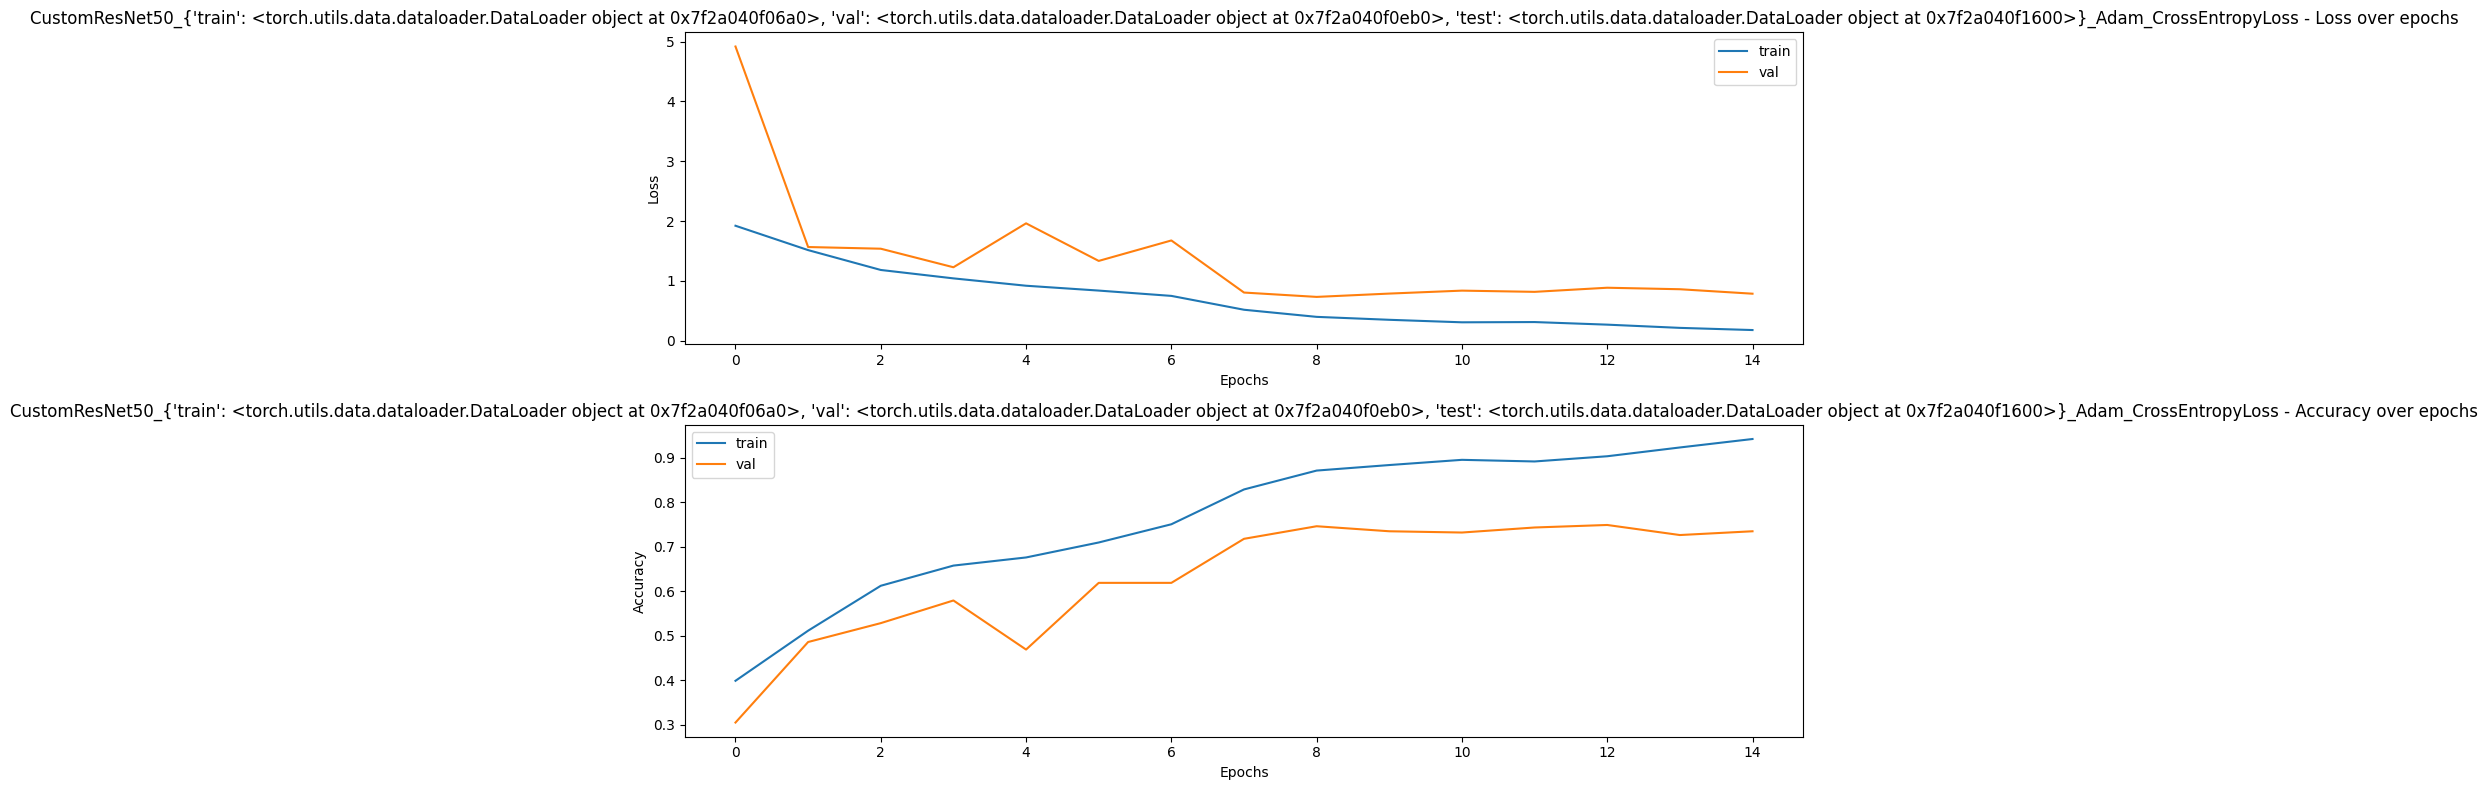


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.5830 Acc: 0.3367
val Loss: 1.3882 Acc: 0.4096

Epoch 1/14
----------
train Loss: 1.0540 Acc: 0.4872
val Loss: 1.5098 Acc: 0.4548

Epoch 2/14
----------
train Loss: 0.8869 Acc: 0.5457
val Loss: 0.9486 Acc: 0.5028

Epoch 3/14
----------
train Loss: 0.6791 Acc: 0.6289
val Loss: 0.8348 Acc: 0.6045

Epoch 4/14
----------
train Loss: 0.6585 Acc: 0.6355
val Loss: 0.9461 Acc: 0.5311

Epoch 5/14
----------
train Loss: 0.5522 Acc: 0.6844
val Loss: 0.8330 Acc: 0.5593

Epoch 6/14
----------
train Loss: 0.4678 Acc: 0.7129
val Loss: 0.6951 Acc: 0.6638

Epoch 7/14
----------
train Loss: 0.2641 Acc: 0.8335
val Loss: 0.5002 Acc: 0.7316

Epoch 8/14
----------
train Loss: 0.2107 Acc: 0.8488
val Loss:

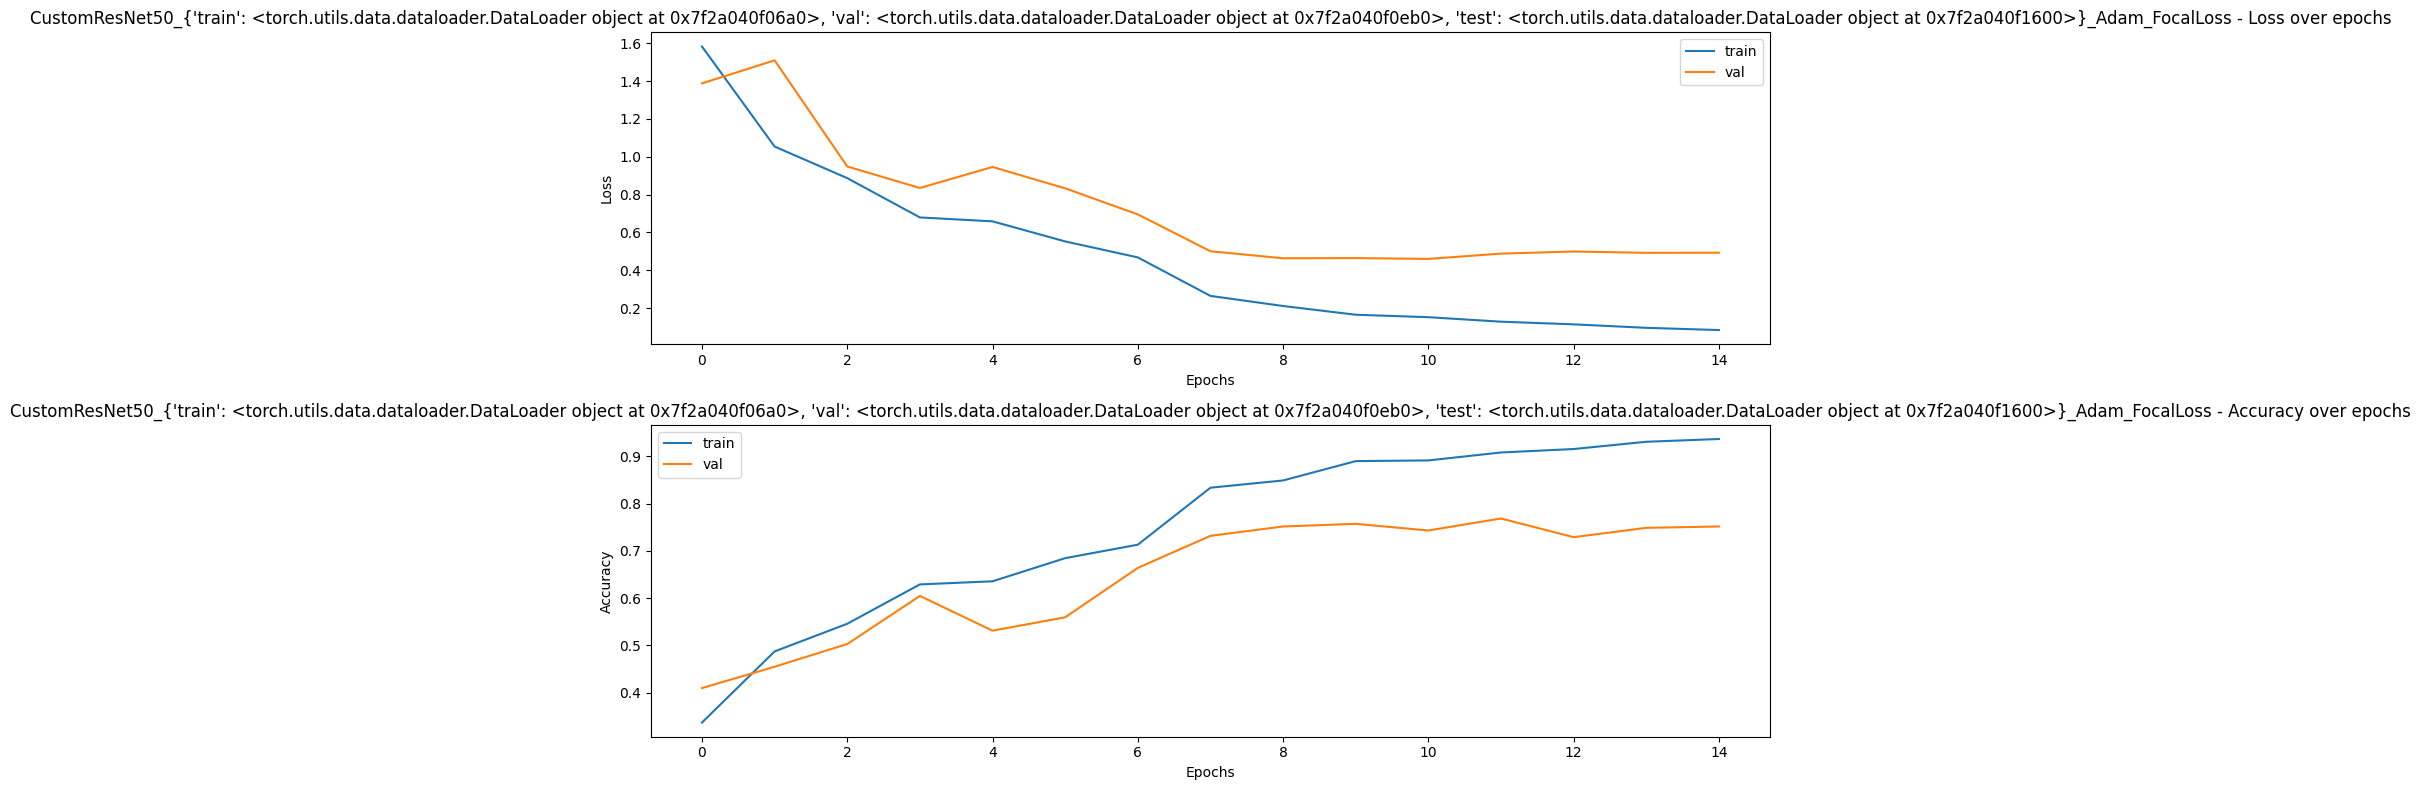


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.4976 Acc: 0.2381
val Loss: 2.0489 Acc: 0.4096

Epoch 1/14
----------
train Loss: 1.6854 Acc: 0.5062
val Loss: 1.3687 Acc: 0.6215

Epoch 2/14
----------
train Loss: 1.1032 Acc: 0.6808
val Loss: 0.9609 Acc: 0.7090

Epoch 3/14
----------
train Loss: 0.7515 Acc: 0.7706
val Loss: 0.8207 Acc: 0.7458

Epoch 4/14
----------
train Loss: 0.5490 Acc: 0.8459
val Loss: 0.6716 Acc: 0.7797

Epoch 5/14
----------
train Loss: 0.3670 Acc: 0.8970
val Loss: 0.7055 Acc: 0.7655

Epoch 6/14
----------
train Loss: 0.2657 Acc: 0.9233
val Loss: 0.6102 Acc: 0.7966

Epoch 7/14
----------
train Loss: 0.2157 Acc: 0.9401
val Loss: 0.5804 Acc: 0.8079

Epoch 8/14
----------
train Loss: 0.1989 Acc: 0.9554
va

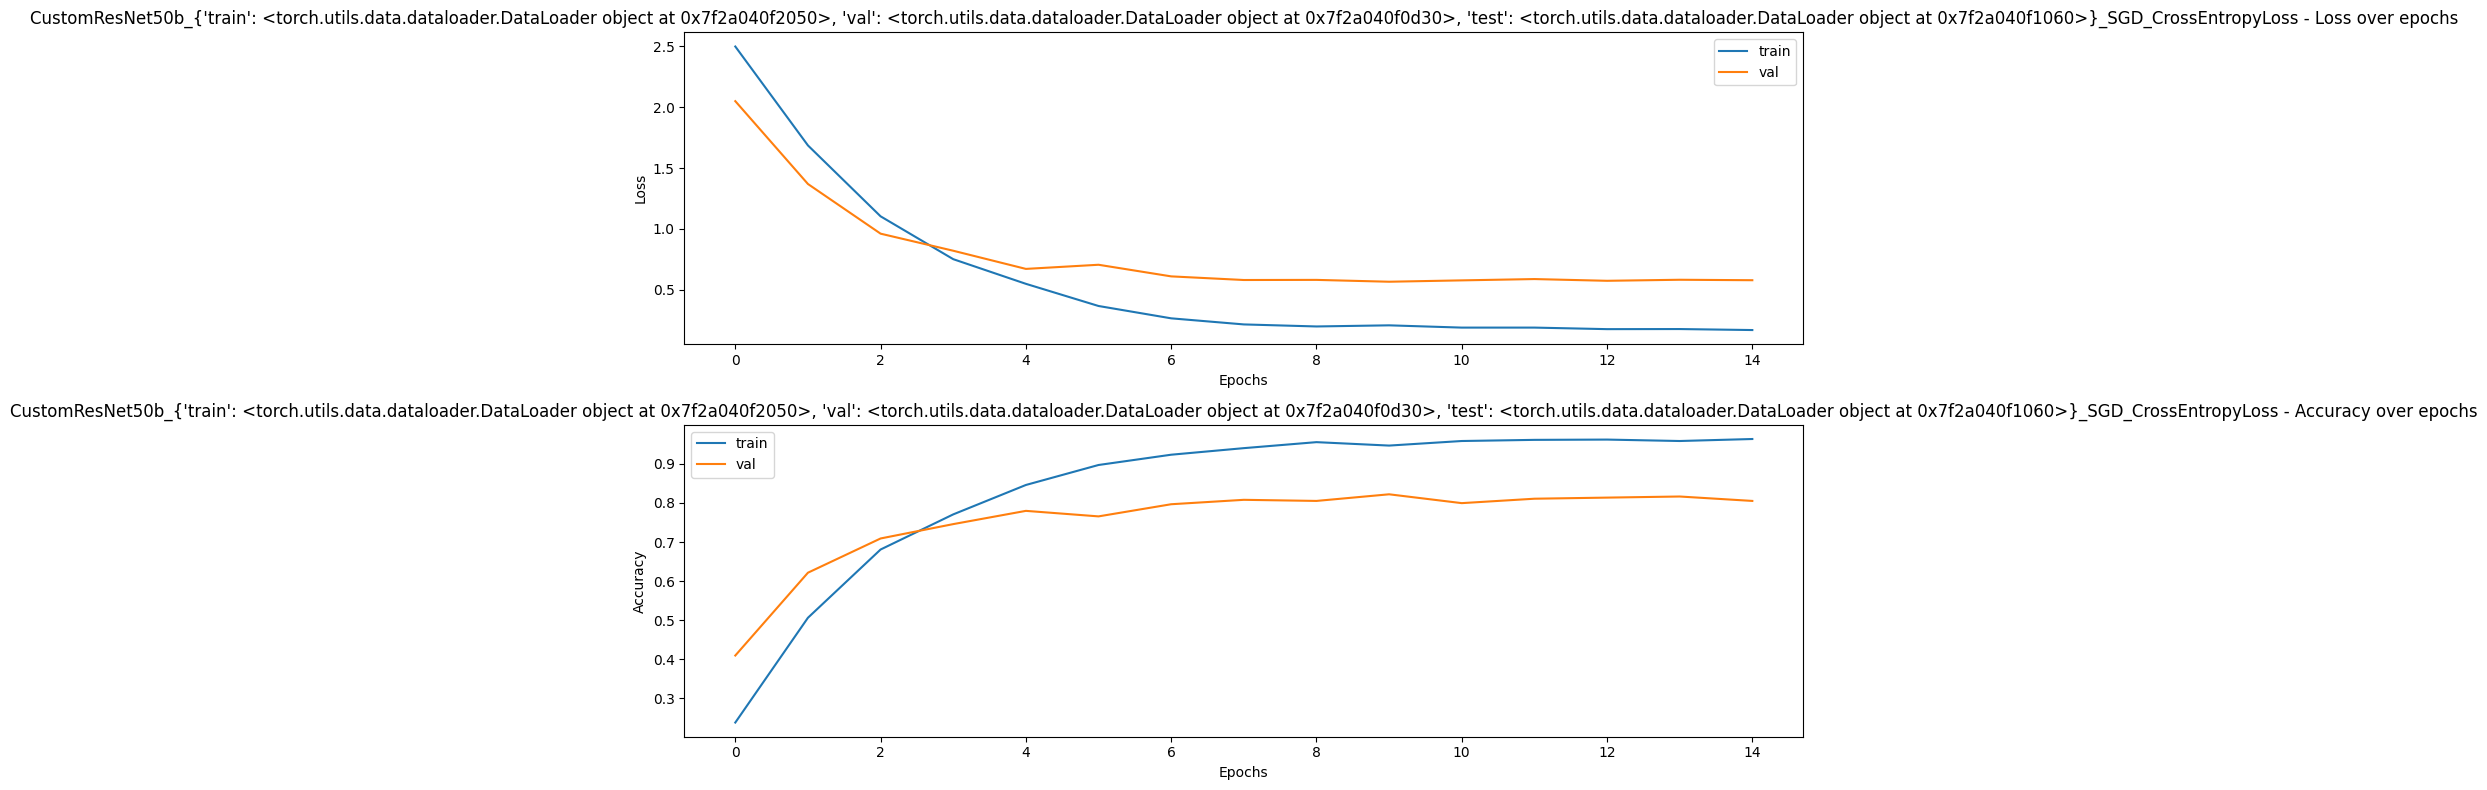


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.0616 Acc: 0.2622
val Loss: 1.5483 Acc: 0.4124

Epoch 1/14
----------
train Loss: 1.1250 Acc: 0.5771
val Loss: 0.8390 Acc: 0.6638

Epoch 2/14
----------
train Loss: 0.6000 Acc: 0.7407
val Loss: 0.6300 Acc: 0.7062

Epoch 3/14
----------
train Loss: 0.3771 Acc: 0.8196
val Loss: 0.4919 Acc: 0.7571

Epoch 4/14
----------
train Loss: 0.2496 Acc: 0.8692
val Loss: 0.4419 Acc: 0.7458

Epoch 5/14
----------
train Loss: 0.1850 Acc: 0.8992
val Loss: 0.4181 Acc: 0.7853

Epoch 6/14
----------
train Loss: 0.1278 Acc: 0.9277
val Loss: 0.3913 Acc: 0.8192

Epoch 7/14
----------
train Loss: 0.0916 Acc: 0.9613
val Loss: 0.3982 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.0824 Acc: 0.9642
val Loss:

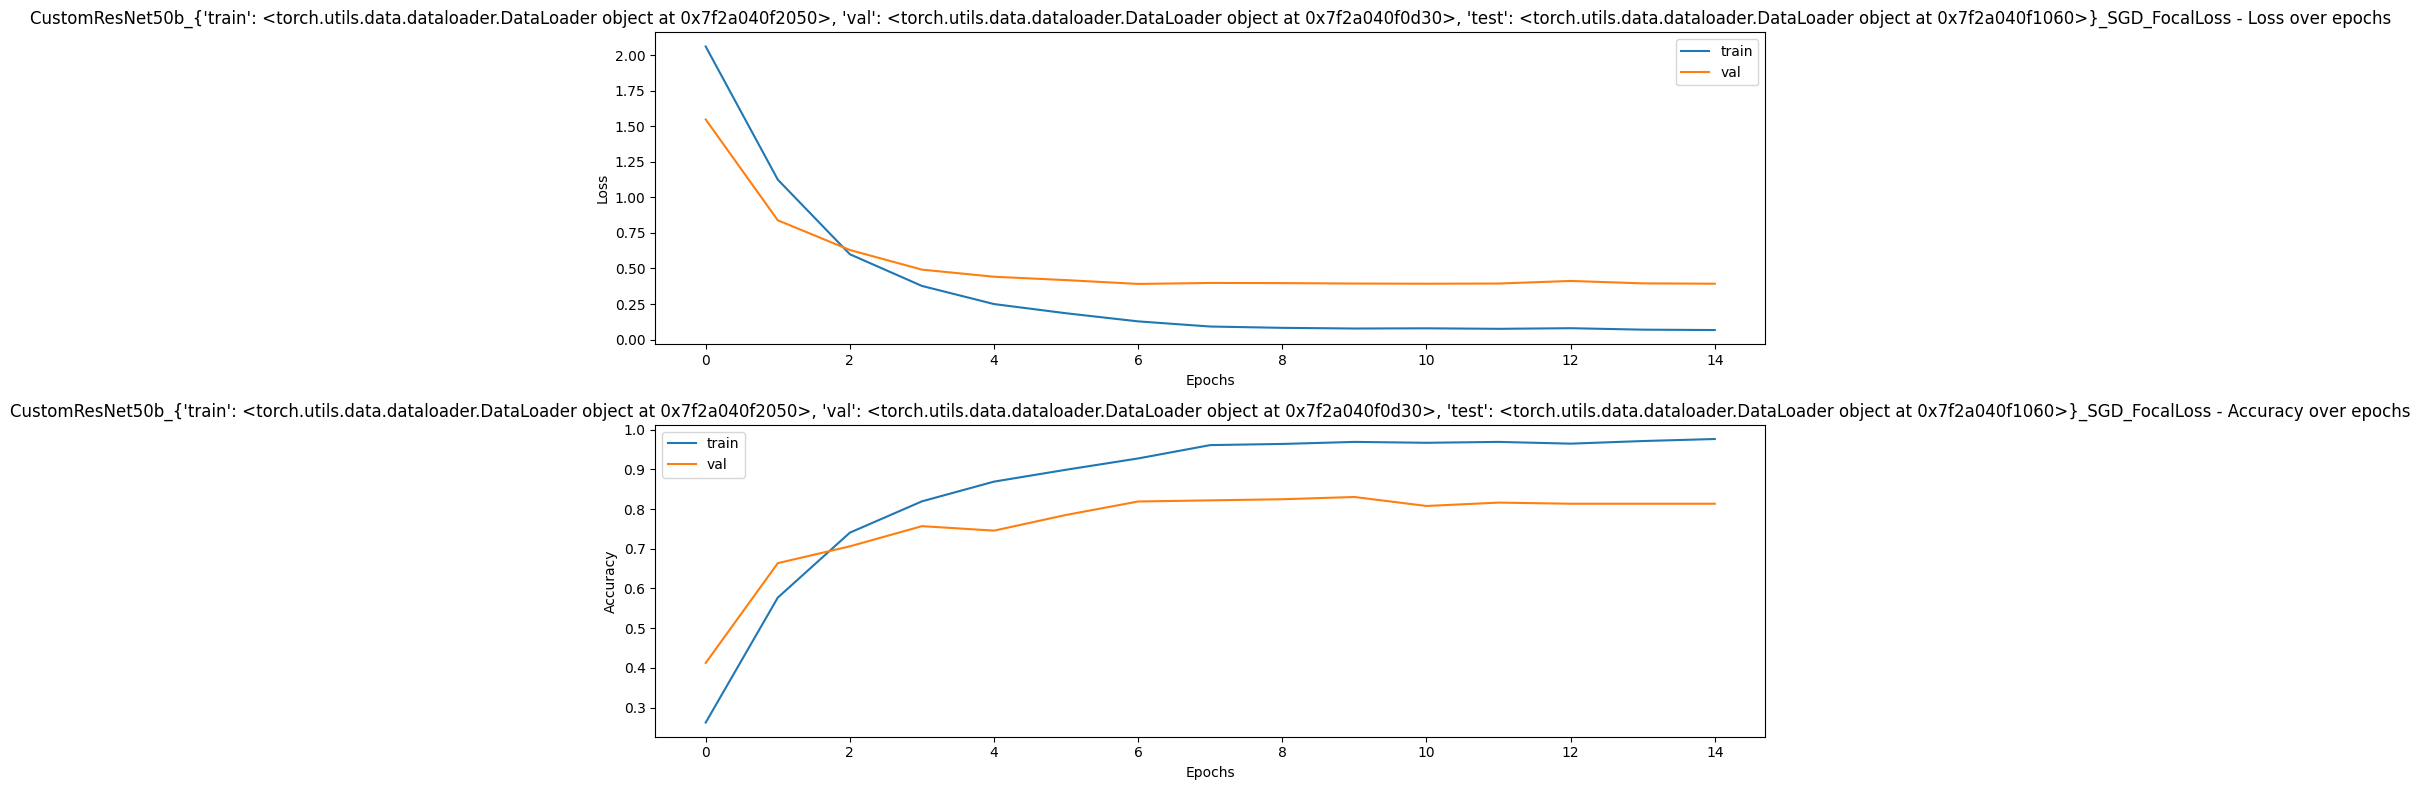


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9303 Acc: 0.3791
val Loss: 3.6849 Acc: 0.3644

Epoch 1/14
----------
train Loss: 1.5074 Acc: 0.4755
val Loss: 2.6251 Acc: 0.3898

Epoch 2/14
----------
train Loss: 1.2942 Acc: 0.5354
val Loss: 1.6342 Acc: 0.4774

Epoch 3/14
----------
train Loss: 1.1781 Acc: 0.5734
val Loss: 2.3177 Acc: 0.4124

Epoch 4/14
----------
train Loss: 1.1128 Acc: 0.6026
val Loss: 2.1934 Acc: 0.4096

Epoch 5/14
----------
train Loss: 1.0480 Acc: 0.6245
val Loss: 3.8629 Acc: 0.3023

Epoch 6/14
----------
train Loss: 0.9267 Acc: 0.6611
val Loss: 1.3793 Acc: 0.5763

Epoch 7/14
----------
train Loss: 0.7022 Acc: 0.7516
val Loss: 0.9670 Acc: 0.6695

Epoch 8/14
----------
train Loss: 0.5972 Acc: 0.7933
v

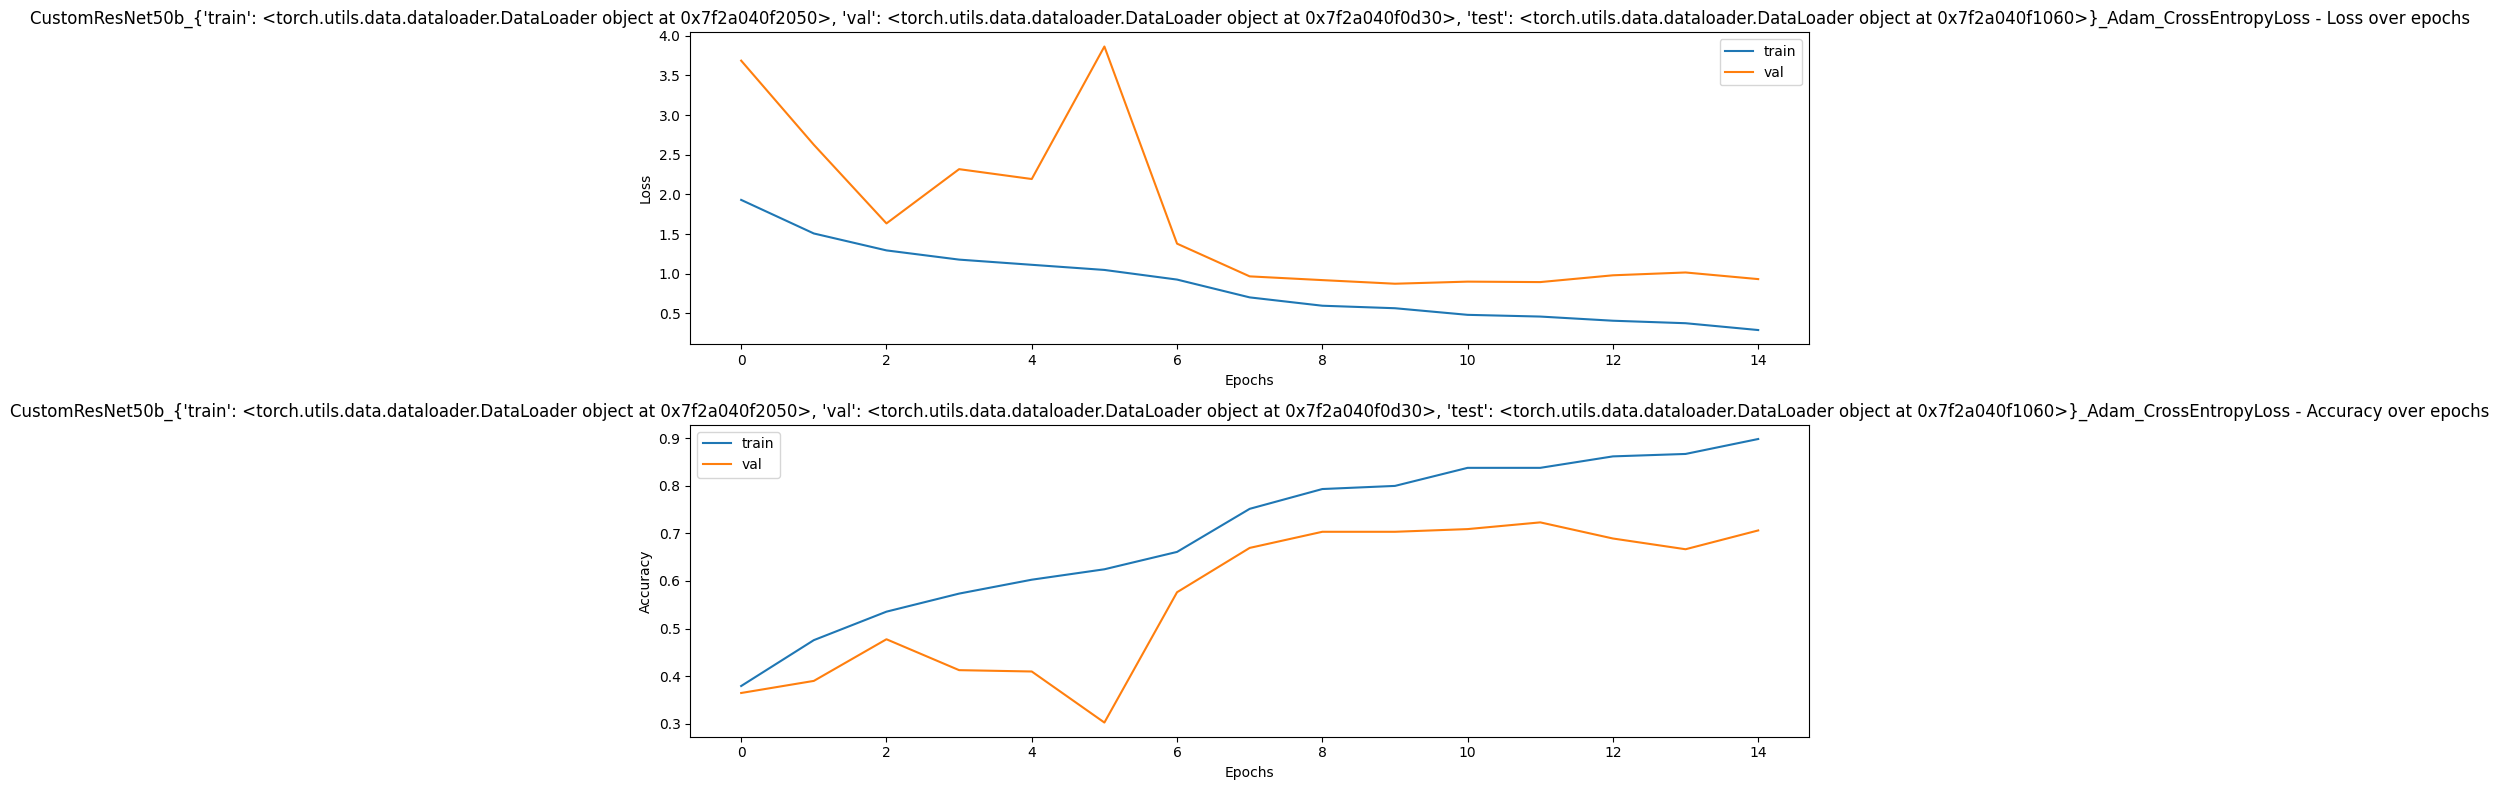


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.4417 Acc: 0.3535
val Loss: 6.2505 Acc: 0.2542

Epoch 1/14
----------
train Loss: 0.9918 Acc: 0.4901
val Loss: 11.8027 Acc: 0.2034

Epoch 2/14
----------
train Loss: 0.8275 Acc: 0.5391
val Loss: 1.3314 Acc: 0.3927

Epoch 3/14
----------
train Loss: 0.8179 Acc: 0.5486
val Loss: 4.0541 Acc: 0.3220

Epoch 4/14
----------
train Loss: 0.7375 Acc: 0.5807
val Loss: 1.8284 Acc: 0.4181

Epoch 5/14
----------
train Loss: 0.6327 Acc: 0.6077
val Loss: 0.8026 Acc: 0.5989

Epoch 6/14
----------
train Loss: 0.5685 Acc: 0.6545
val Loss: 0.7855 Acc: 0.6073

Epoch 7/14
----------
train Loss: 0.4052 Acc: 0.7451
val Loss: 0.6619 Acc: 0.6667

Epoch 8/14
----------
train Loss: 0.3250 Acc: 0.7765
val Los

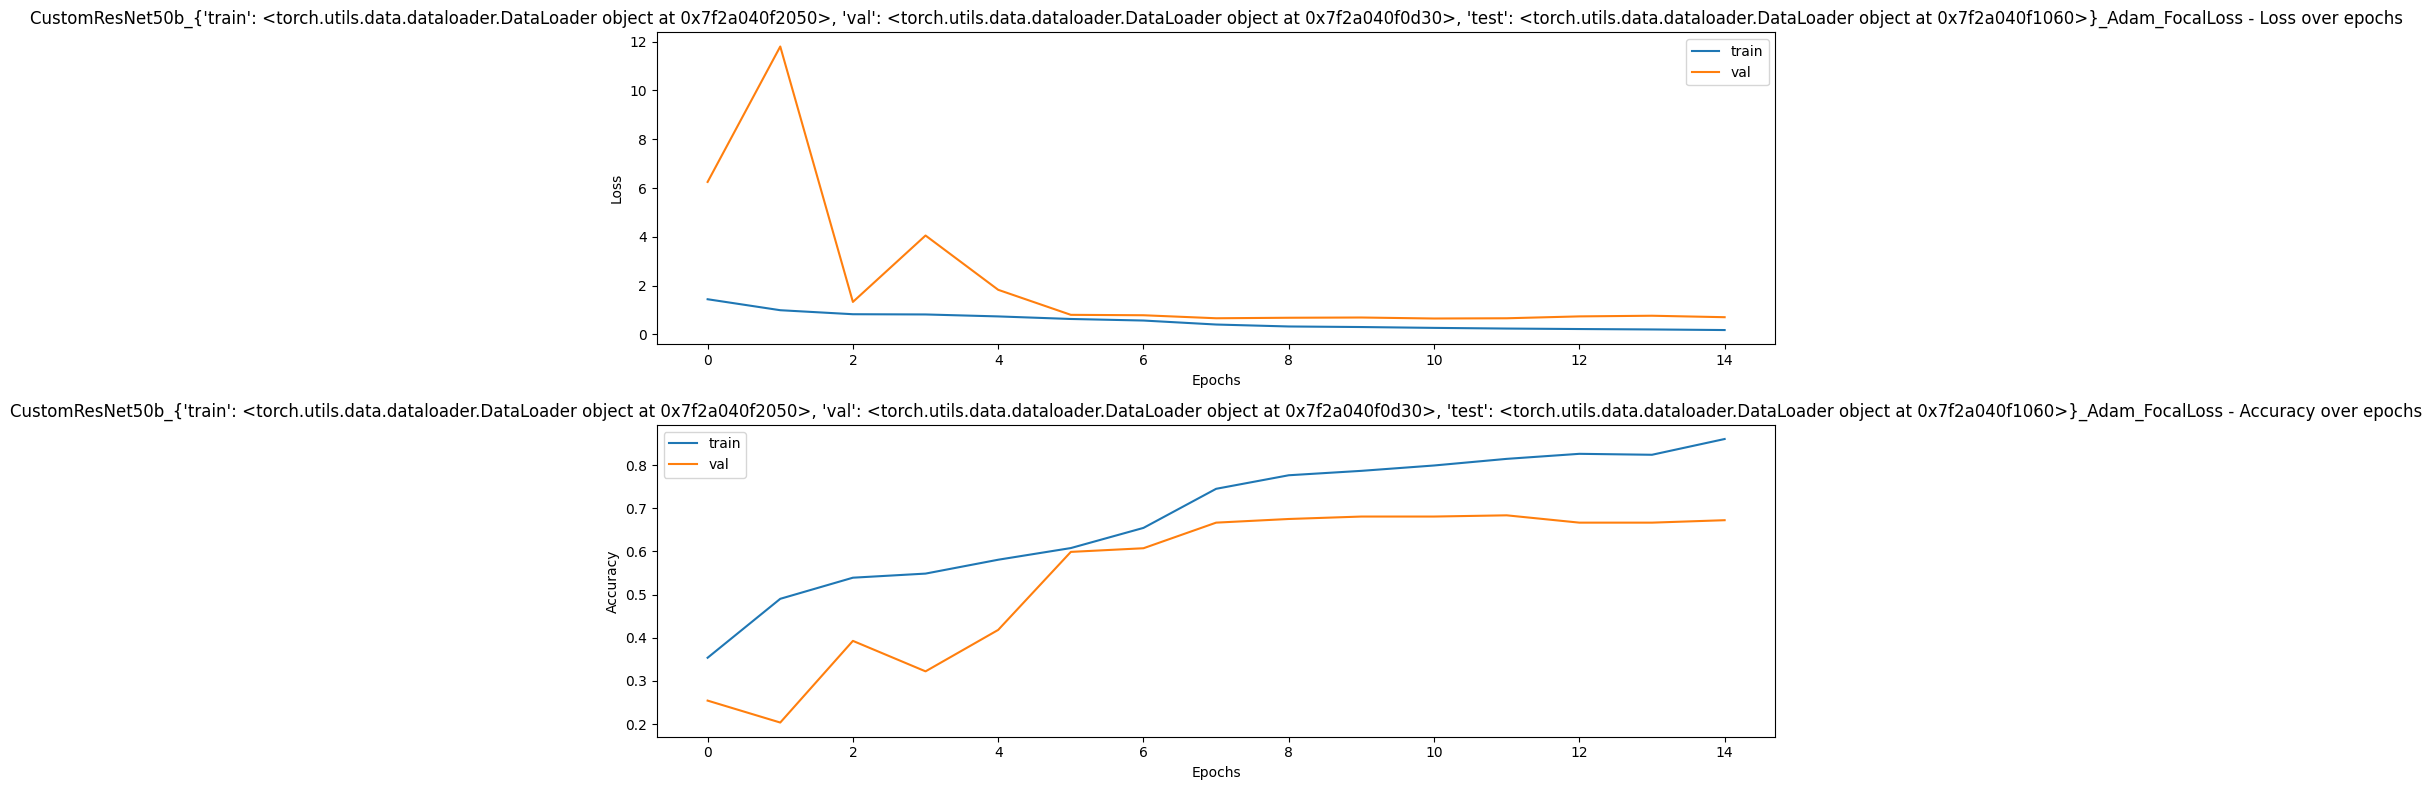


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5307 Acc: 0.2177
val Loss: 2.1588 Acc: 0.3192

Epoch 1/14
----------
train Loss: 1.7942 Acc: 0.4675
val Loss: 1.4589 Acc: 0.5565

Epoch 2/14
----------
train Loss: 1.2226 Acc: 0.6311
val Loss: 1.0942 Acc: 0.6695

Epoch 3/14
----------
train Loss: 0.8726 Acc: 0.7458
val Loss: 0.9338 Acc: 0.7006

Epoch 4/14
----------
train Loss: 0.6741 Acc: 0.8020
val Loss: 0.8754 Acc: 0.7006

Epoch 5/14
----------
train Loss: 0.5103 Acc: 0.8495
val Loss: 0.7550 Acc: 0.7655

Epoch 6/14
----------
train Loss: 0.4003 Acc: 0.8868
val Loss: 0.6842 Acc: 0.7825

Epoch 7/14
----------
train Loss: 0.2918 Acc: 0.9233
val Loss: 0.6354 Acc: 0.7910

Epoch 8/14
----------
train Loss: 0.2840 Acc: 0.9131
va

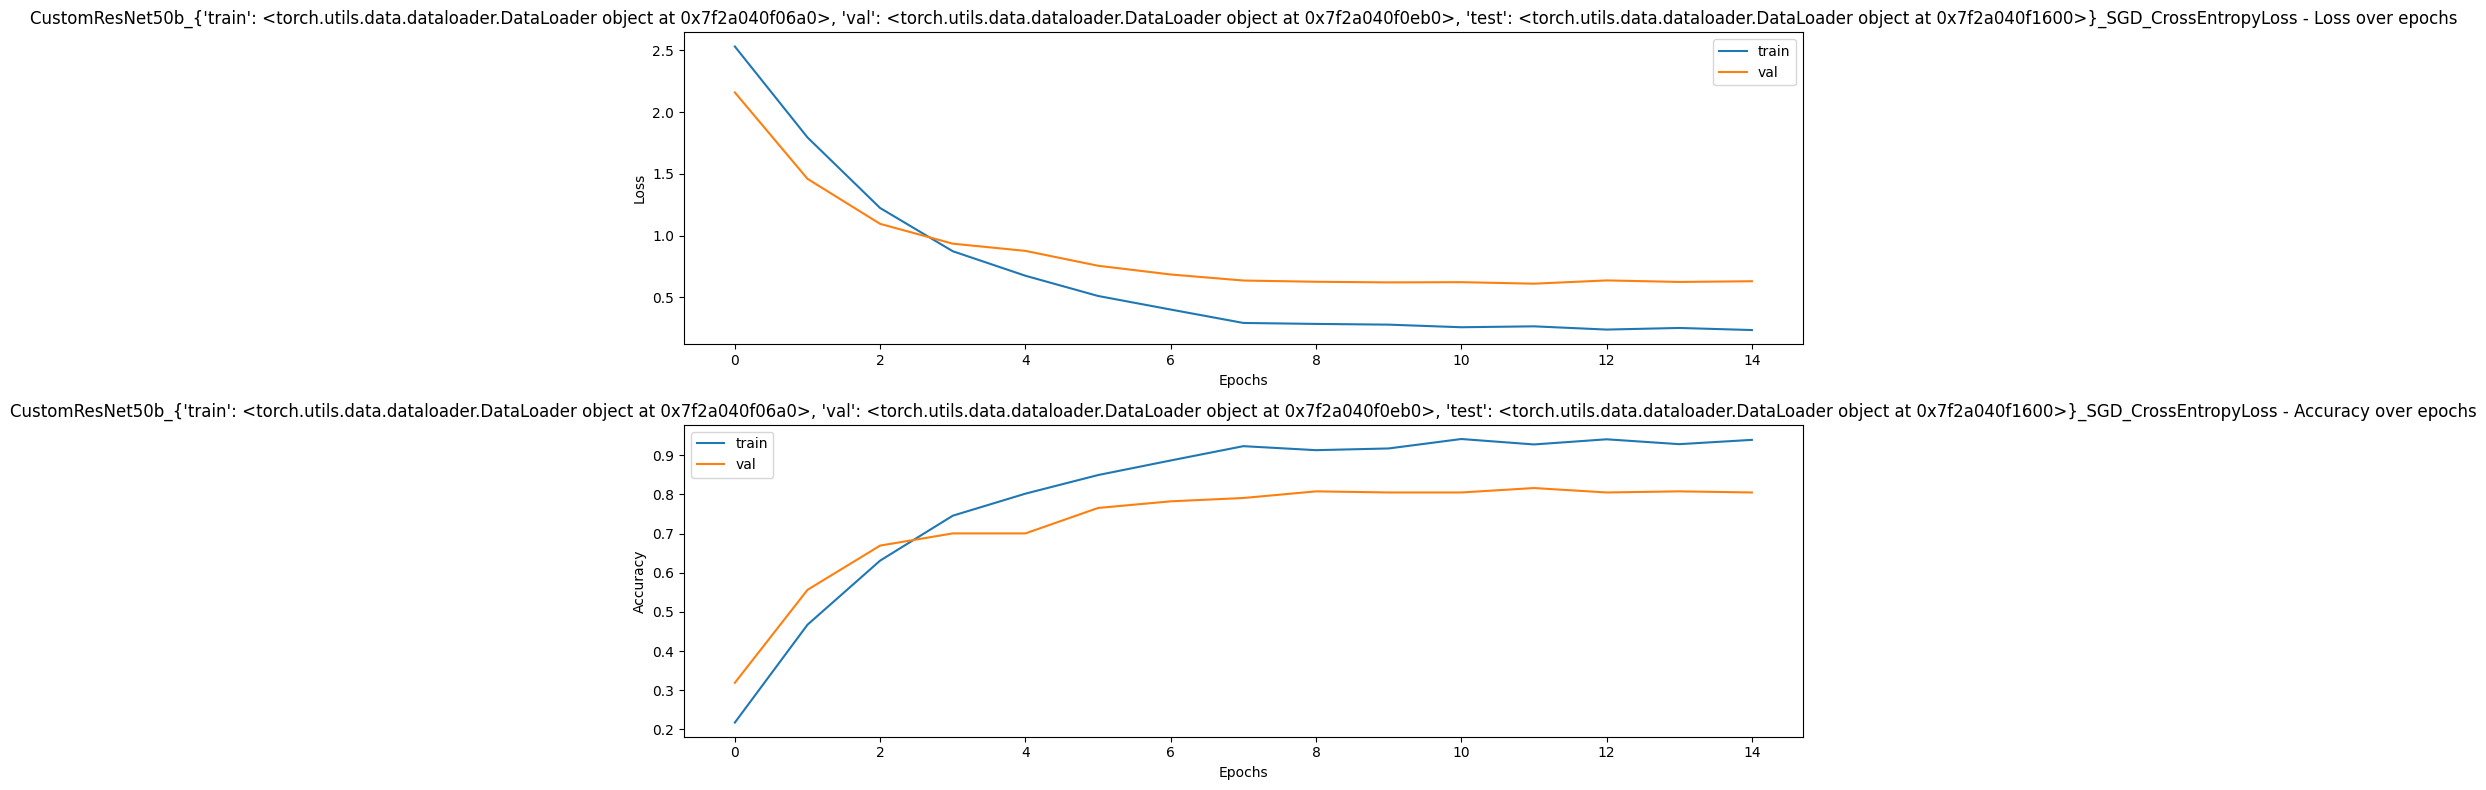


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.1408 Acc: 0.2279
val Loss: 1.6505 Acc: 0.3955

Epoch 1/14
----------
train Loss: 1.2456 Acc: 0.5179
val Loss: 0.9289 Acc: 0.5960

Epoch 2/14
----------
train Loss: 0.7139 Acc: 0.6881
val Loss: 0.6528 Acc: 0.6469

Epoch 3/14
----------
train Loss: 0.4787 Acc: 0.7684
val Loss: 0.5227 Acc: 0.7514

Epoch 4/14
----------
train Loss: 0.3681 Acc: 0.8050
val Loss: 0.4875 Acc: 0.7486

Epoch 5/14
----------
train Loss: 0.2555 Acc: 0.8692
val Loss: 0.4488 Acc: 0.7797

Epoch 6/14
----------
train Loss: 0.1829 Acc: 0.8897
val Loss: 0.4231 Acc: 0.7825

Epoch 7/14
----------
train Loss: 0.1418 Acc: 0.9218
val Loss: 0.3963 Acc: 0.8079

Epoch 8/14
----------
train Loss: 0.1399 Acc: 0.9211
val Loss:

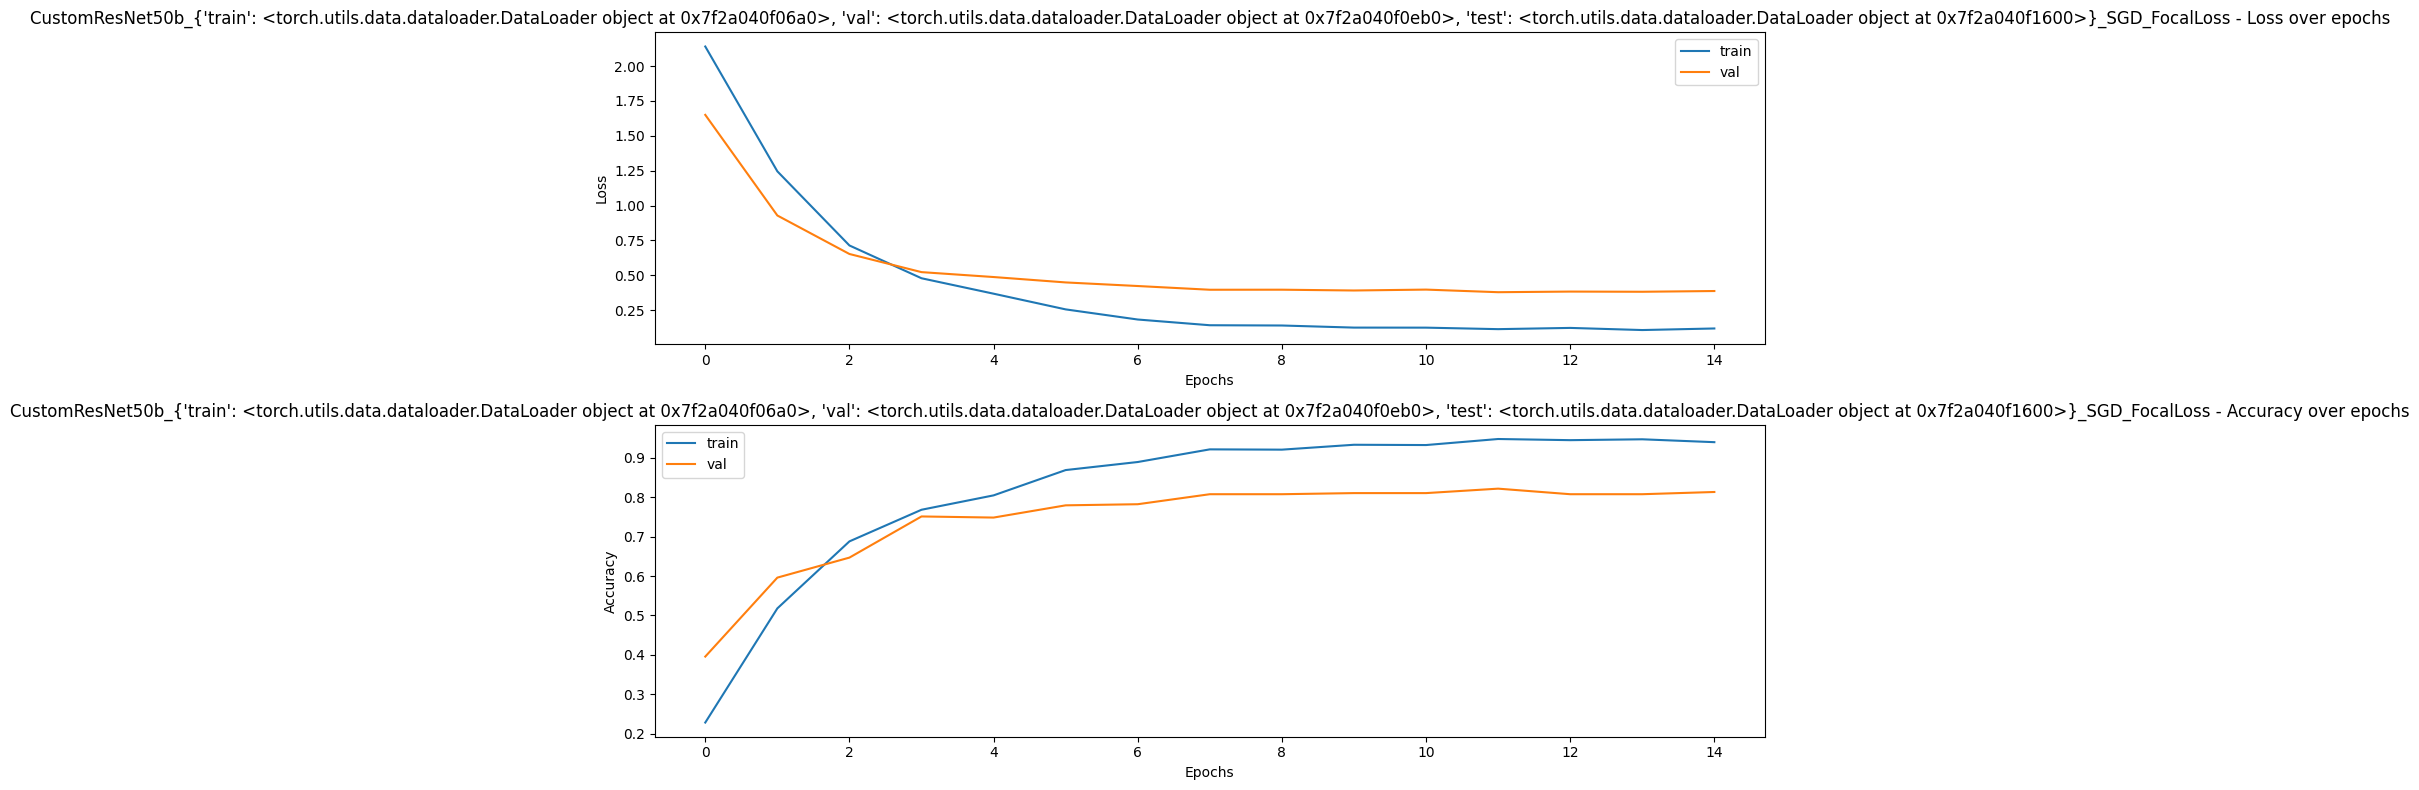


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.2536 Acc: 0.2900
val Loss: 3.4995 Acc: 0.2119

Epoch 1/14
----------
train Loss: 1.7783 Acc: 0.3923
val Loss: 3.6844 Acc: 0.2712

Epoch 2/14
----------
train Loss: 1.6064 Acc: 0.4668
val Loss: 1.5378 Acc: 0.5113

Epoch 3/14
----------
train Loss: 1.4109 Acc: 0.4938
val Loss: 1.6738 Acc: 0.4435

Epoch 4/14
----------
train Loss: 1.2602 Acc: 0.5727
val Loss: 2.0033 Acc: 0.3842

Epoch 5/14
----------
train Loss: 1.1070 Acc: 0.6136
val Loss: 1.2752 Acc: 0.5819

Epoch 6/14
----------
train Loss: 1.0886 Acc: 0.6129
val Loss: 1.3911 Acc: 0.5028

Epoch 7/14
----------
train Loss: 0.8529 Acc: 0.7093
val Loss: 1.1704 Acc: 0.6130

Epoch 8/14
----------
train Loss: 0.7652 Acc: 0.7268
v

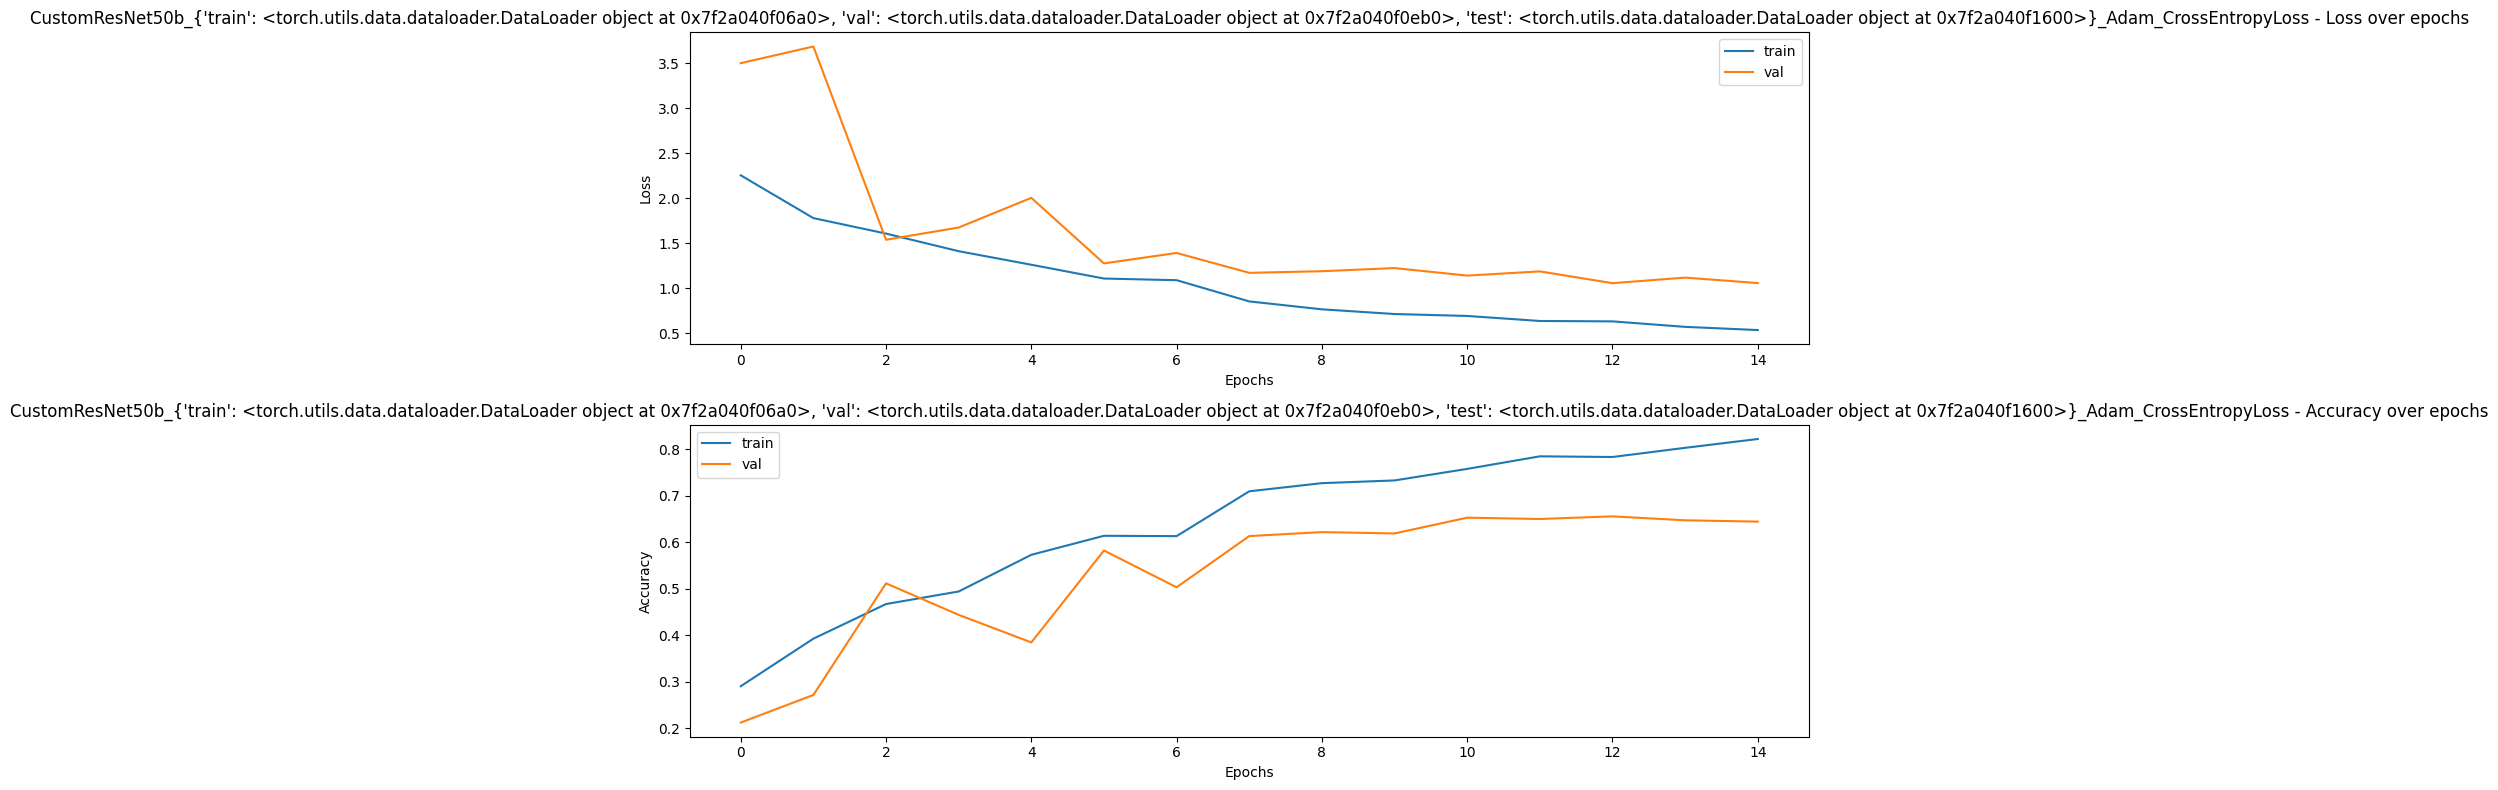


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 2.0909 Acc: 0.1921
val Loss: 1.8370 Acc: 0.2853

Epoch 1/14
----------
train Loss: 1.5697 Acc: 0.2805
val Loss: 2.1717 Acc: 0.2006

Epoch 2/14
----------
train Loss: 1.2474 Acc: 0.3952
val Loss: 1.4757 Acc: 0.3446

Epoch 3/14
----------
train Loss: 1.1703 Acc: 0.4069
val Loss: 1.3225 Acc: 0.4209

Epoch 4/14
----------
train Loss: 1.0855 Acc: 0.4492
val Loss: 2.9604 Acc: 0.3418

Epoch 5/14
----------
train Loss: 0.9208 Acc: 0.4974
val Loss: 3.2816 Acc: 0.2260

Epoch 6/14
----------
train Loss: 0.8474 Acc: 0.5150
val Loss: 1.0543 Acc: 0.4802

Epoch 7/14
----------
train Loss: 0.7058 Acc: 0.5705
val Loss: 0.8228 Acc: 0.5565

Epoch 8/14
----------
train Loss: 0.6046 Acc: 0.6224
val Loss

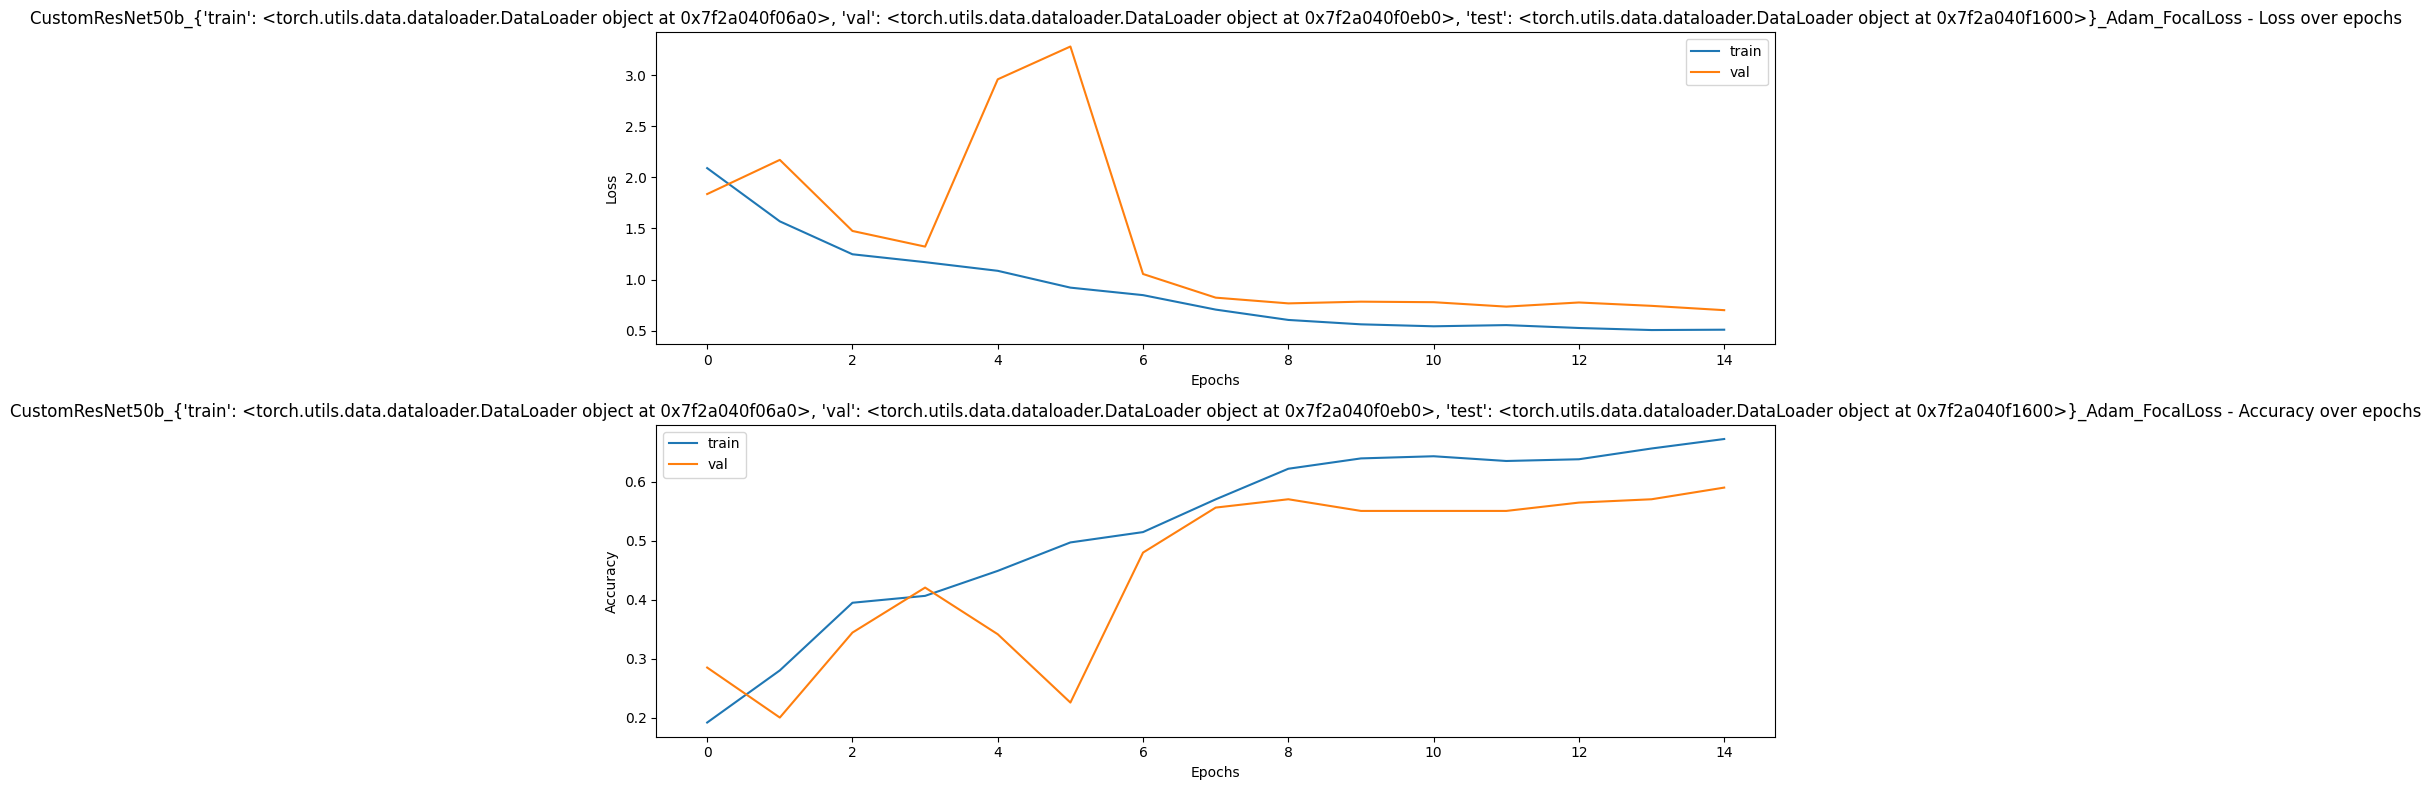

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, SGD, CrossEntropyLoss


100%|██████████| 30.8M/30.8M [00:00<00:00, 315MB/s]


Epoch 0/14
----------
train Loss: 1.8253 Acc: 0.4697
val Loss: 1.1593 Acc: 0.6667

Epoch 1/14
----------
train Loss: 0.8540 Acc: 0.7487
val Loss: 0.8224 Acc: 0.7486

Epoch 2/14
----------
train Loss: 0.5336 Acc: 0.8503
val Loss: 0.7227 Acc: 0.7627

Epoch 3/14
----------
train Loss: 0.3608 Acc: 0.9080
val Loss: 0.5961 Acc: 0.8164

Epoch 4/14
----------
train Loss: 0.2439 Acc: 0.9474
val Loss: 0.5898 Acc: 0.8305

Epoch 5/14
----------
train Loss: 0.1752 Acc: 0.9671
val Loss: 0.5800 Acc: 0.8390

Epoch 6/14
----------
train Loss: 0.1272 Acc: 0.9803
val Loss: 0.6125 Acc: 0.8277

Epoch 7/14
----------
train Loss: 0.1005 Acc: 0.9898
val Loss: 0.5635 Acc: 0.8531

Epoch 8/14
----------
train Loss: 0.0844 Acc: 0.9912
val Loss: 0.5544 Acc: 0.8503

Epoch 9/14
----------
train Loss: 0.0808 Acc: 0.9905
val Loss: 0.5641 Acc: 0.8390

Epoch 10/14
----------
train Loss: 0.0778 Acc: 0.9949
val Loss: 0.5904 Acc: 0.8418

Epoch 11/14
----------
train Loss: 0.0749 Acc: 0.9934
val Loss: 0.5569 Acc: 0.8446

Ep

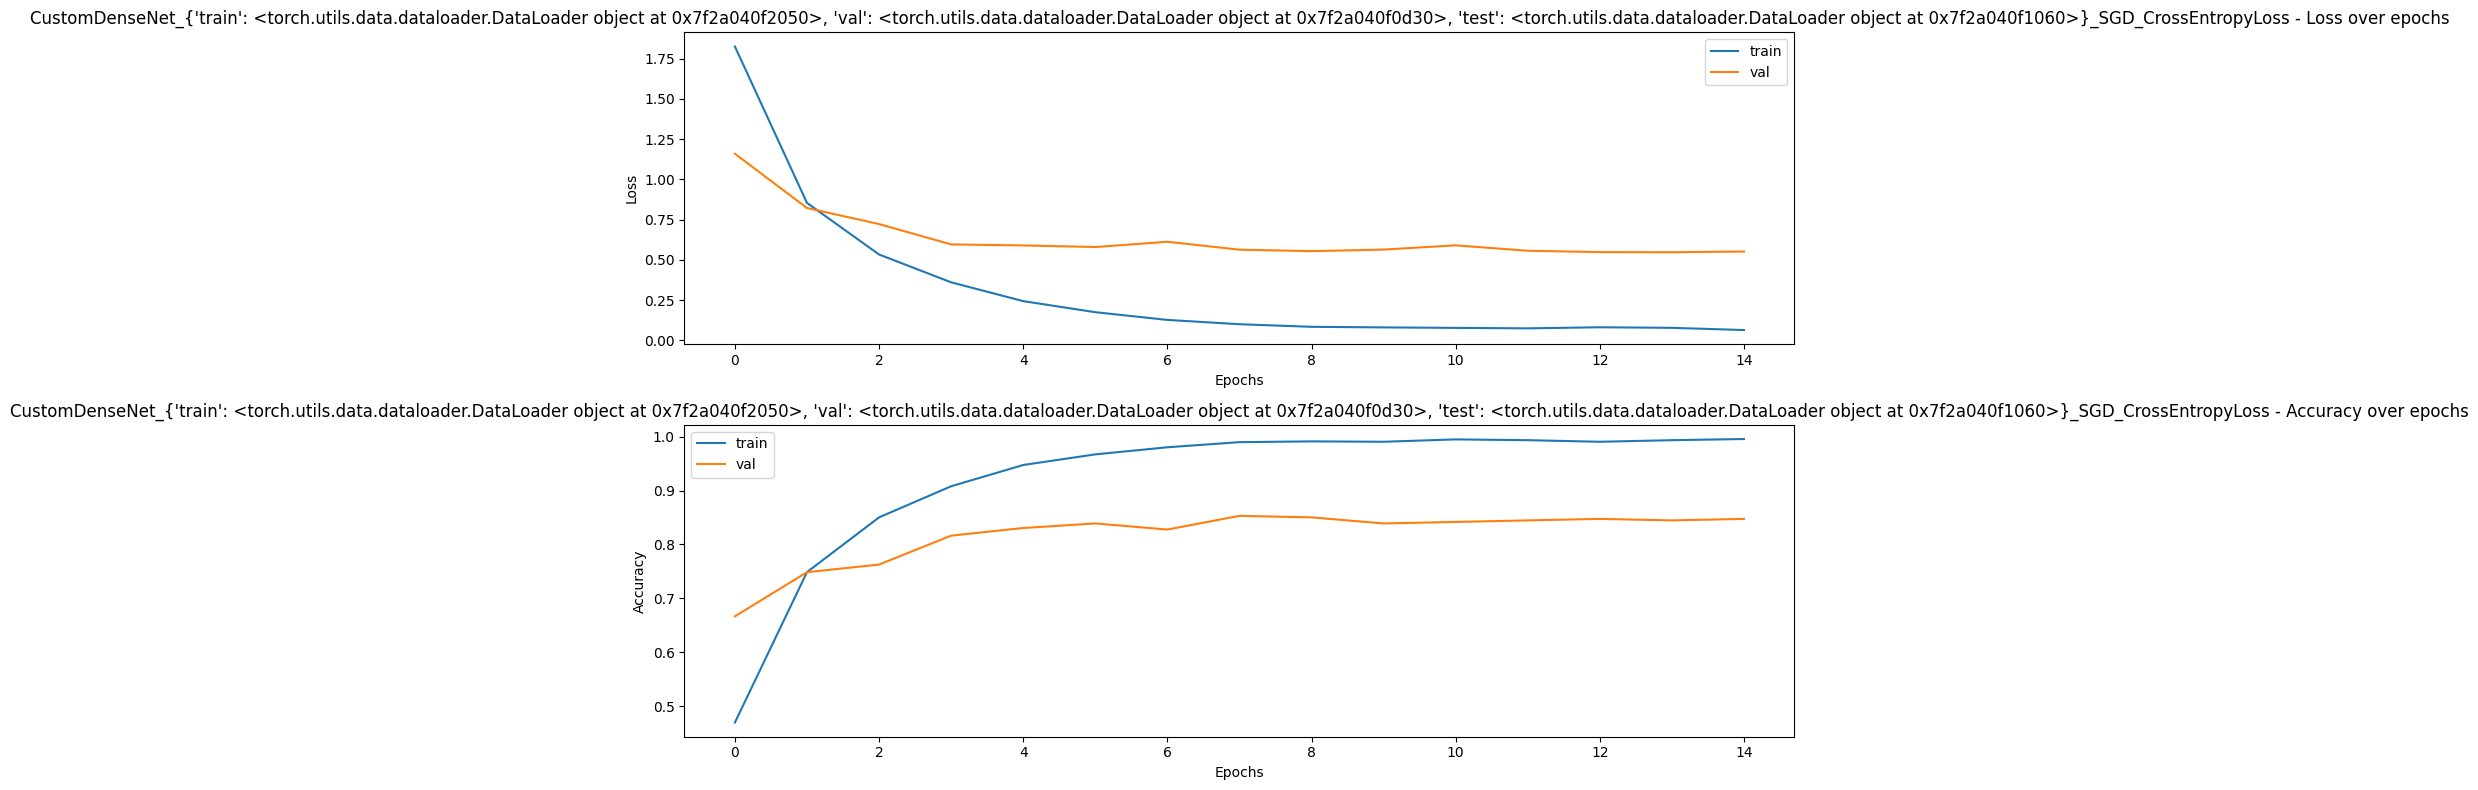


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3140 Acc: 0.5062
val Loss: 0.6852 Acc: 0.7006

Epoch 1/14
----------
train Loss: 0.4350 Acc: 0.8064
val Loss: 0.5705 Acc: 0.7514

Epoch 2/14
----------
train Loss: 0.2846 Acc: 0.8598
val Loss: 0.4249 Acc: 0.7938

Epoch 3/14
----------
train Loss: 0.1481 Acc: 0.9255
val Loss: 0.3859 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.0976 Acc: 0.9554
val Loss: 0.3473 Acc: 0.8277

Epoch 5/14
----------
train Loss: 0.0606 Acc: 0.9803
val Loss: 0.3739 Acc: 0.8164

Epoch 6/14
----------
train Loss: 0.0457 Acc: 0.9854
val Loss: 0.3695 Acc: 0.8079

Epoch 7/14
----------
train Loss: 0.0335 Acc: 0.9898
val Loss: 0.3542 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.0338 Acc: 0.9920
val Loss: 

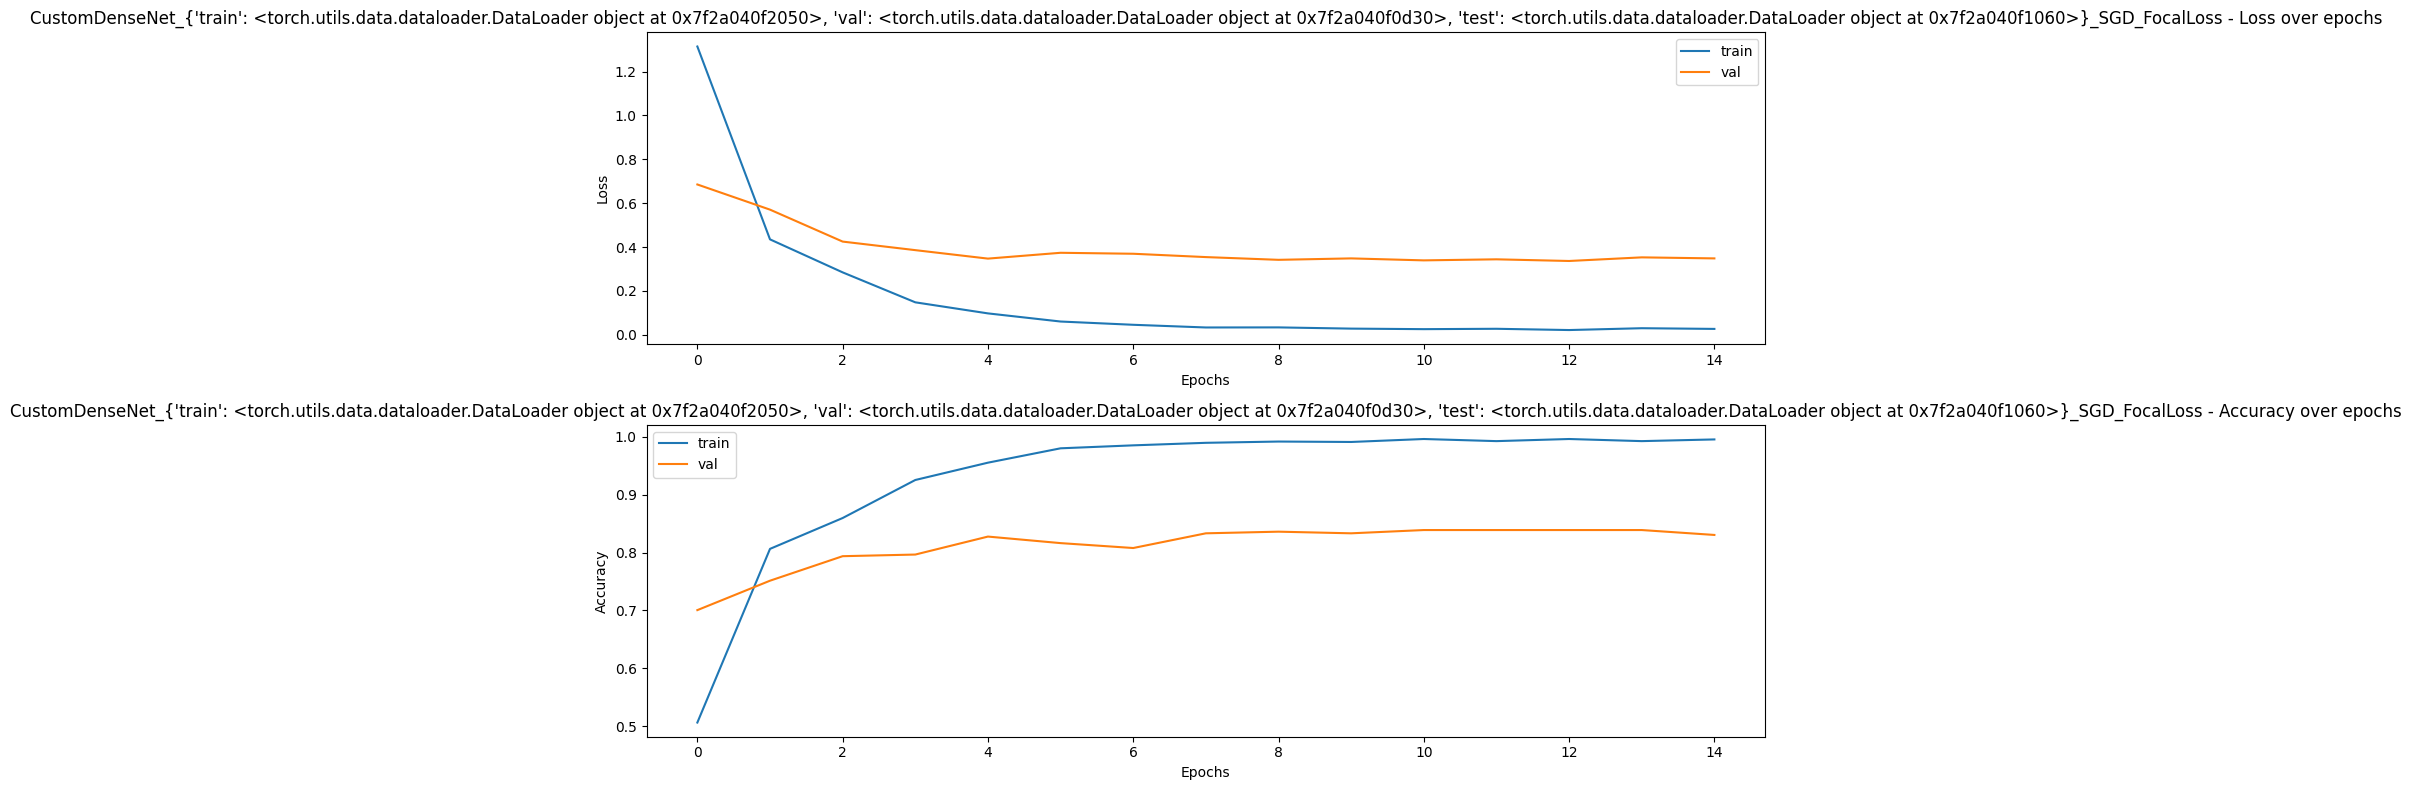


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.2199 Acc: 0.6245
val Loss: 1.5300 Acc: 0.5989

Epoch 1/14
----------
train Loss: 0.7991 Acc: 0.7480
val Loss: 1.1322 Acc: 0.6836

Epoch 2/14
----------
train Loss: 0.5803 Acc: 0.8181
val Loss: 1.0018 Acc: 0.7147

Epoch 3/14
----------
train Loss: 0.4597 Acc: 0.8590
val Loss: 0.8700 Acc: 0.7006

Epoch 4/14
----------
train Loss: 0.4259 Acc: 0.8671
val Loss: 1.6202 Acc: 0.6299

Epoch 5/14
----------
train Loss: 0.4003 Acc: 0.8605
val Loss: 1.0983 Acc: 0.6893

Epoch 6/14
----------
train Loss: 0.3580 Acc: 0.8744
val Loss: 0.6688 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.1637 Acc: 0.9445
val Loss: 0.4927 Acc: 0.8588

Epoch 8/14
----------
train Loss: 0.1128 Acc: 0.9730
va

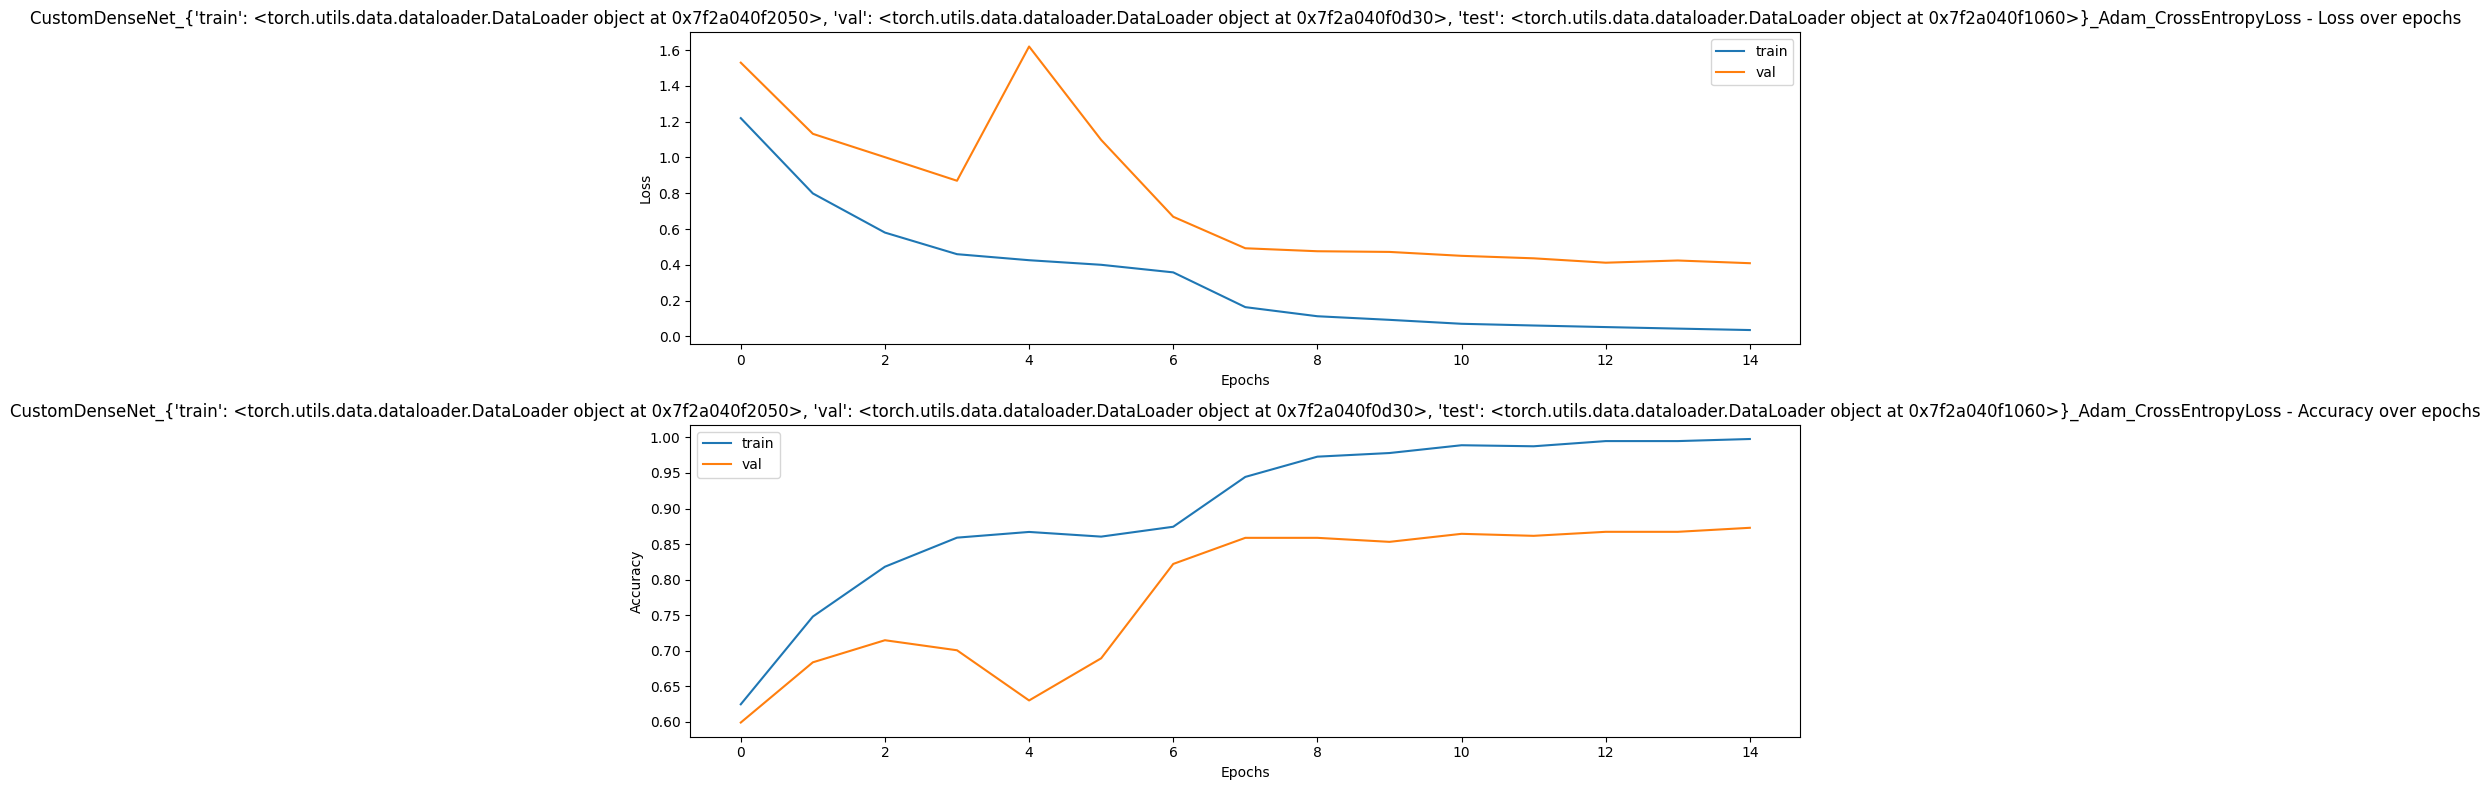


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f2050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0d30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1060>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9208 Acc: 0.5888
val Loss: 0.7505 Acc: 0.6469

Epoch 1/14
----------
train Loss: 0.4676 Acc: 0.7553
val Loss: 1.0897 Acc: 0.5621

Epoch 2/14
----------
train Loss: 0.3801 Acc: 0.7867
val Loss: 0.9209 Acc: 0.5763

Epoch 3/14
----------
train Loss: 0.3045 Acc: 0.8196
val Loss: 0.4830 Acc: 0.7316

Epoch 4/14
----------
train Loss: 0.2138 Acc: 0.8554
val Loss: 0.6822 Acc: 0.7288

Epoch 5/14
----------
train Loss: 0.1718 Acc: 0.8780
val Loss: 0.5239 Acc: 0.7712

Epoch 6/14
----------
train Loss: 0.1722 Acc: 0.8839
val Loss: 0.6025 Acc: 0.7655

Epoch 7/14
----------
train Loss: 0.0685 Acc: 0.9503
val Loss: 0.3543 Acc: 0.8418

Epoch 8/14
----------
train Loss: 0.0461 Acc: 0.9584
val Loss:

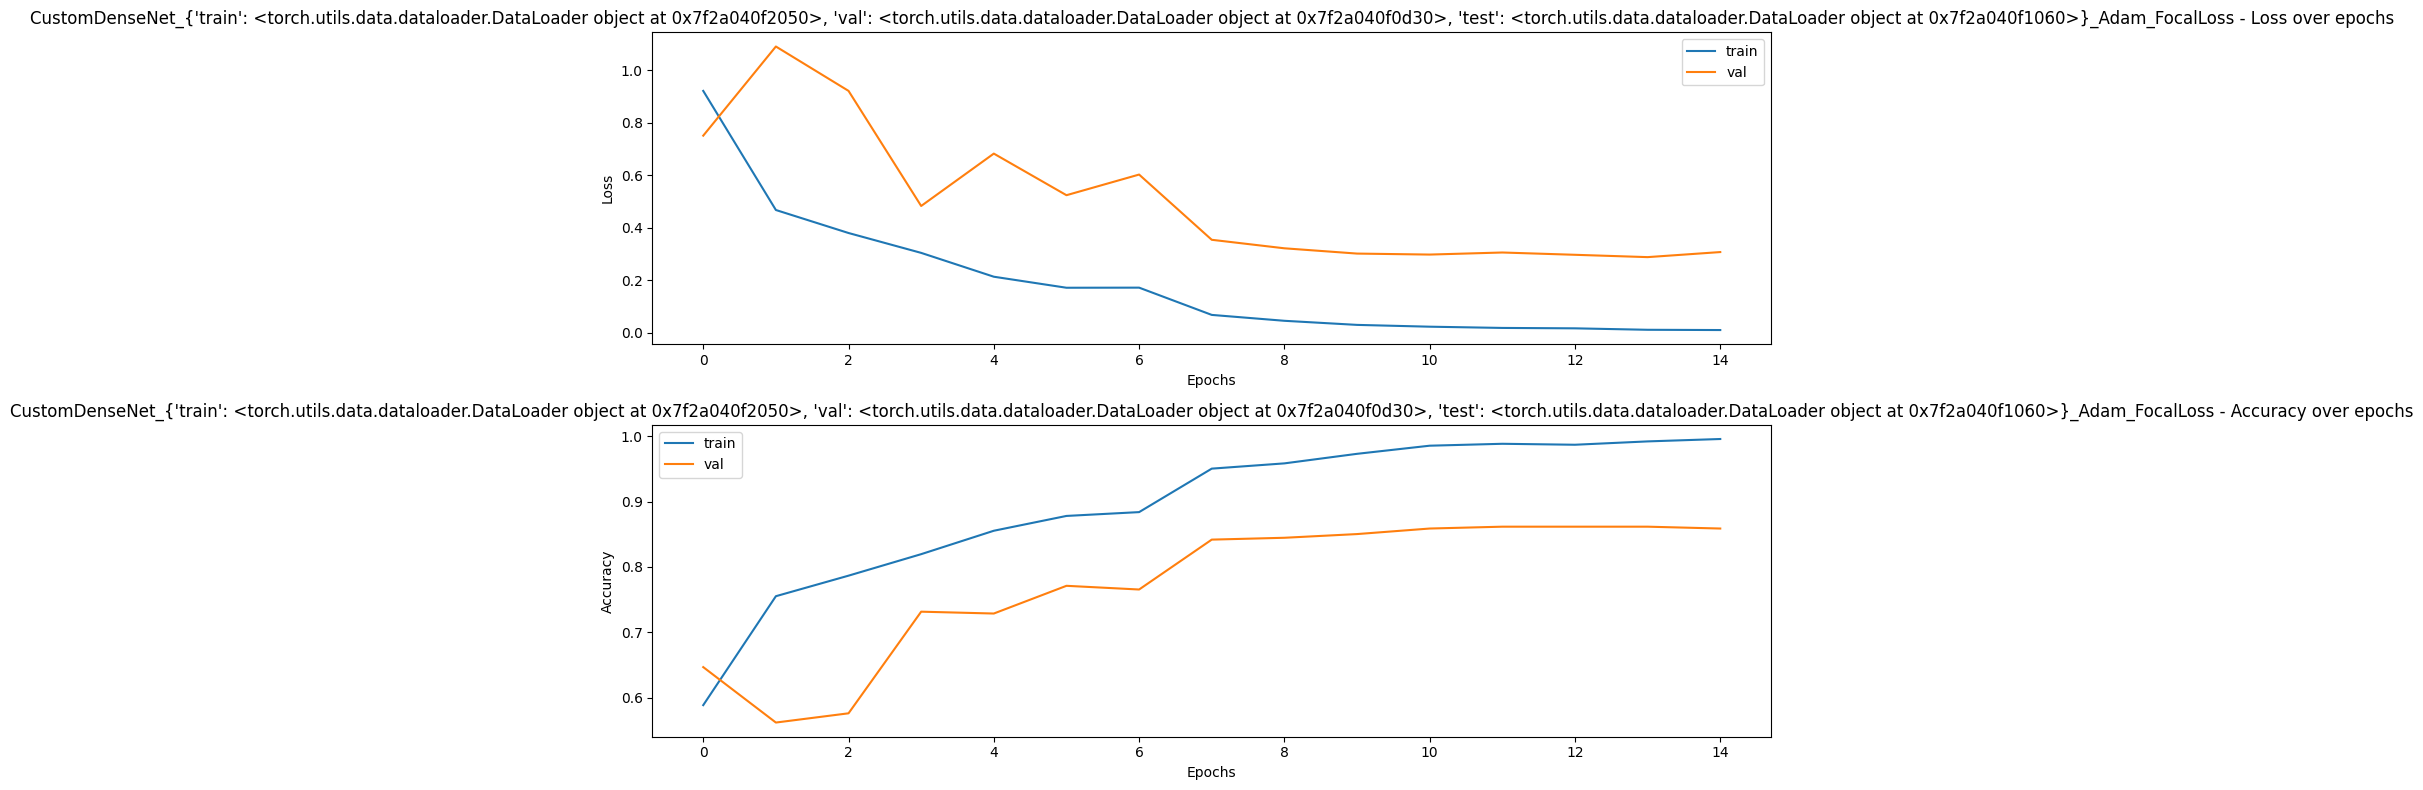


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9225 Acc: 0.4105
val Loss: 1.1427 Acc: 0.6949

Epoch 1/14
----------
train Loss: 0.9311 Acc: 0.7531
val Loss: 0.8160 Acc: 0.7288

Epoch 2/14
----------
train Loss: 0.6381 Acc: 0.8101
val Loss: 0.6259 Acc: 0.7994

Epoch 3/14
----------
train Loss: 0.4462 Acc: 0.8744
val Loss: 0.5550 Acc: 0.8475

Epoch 4/14
----------
train Loss: 0.3526 Acc: 0.9072
val Loss: 0.5731 Acc: 0.8051

Epoch 5/14
----------
train Loss: 0.2652 Acc: 0.9233
val Loss: 0.5471 Acc: 0.8220

Epoch 6/14
----------
train Loss: 0.2215 Acc: 0.9445
val Loss: 0.5142 Acc: 0.8446

Epoch 7/14
----------
train Loss: 0.1543 Acc: 0.9715
val Loss: 0.4687 Acc: 0.8616

Epoch 8/14
----------
train Loss: 0.1471 Acc: 0.9715
val

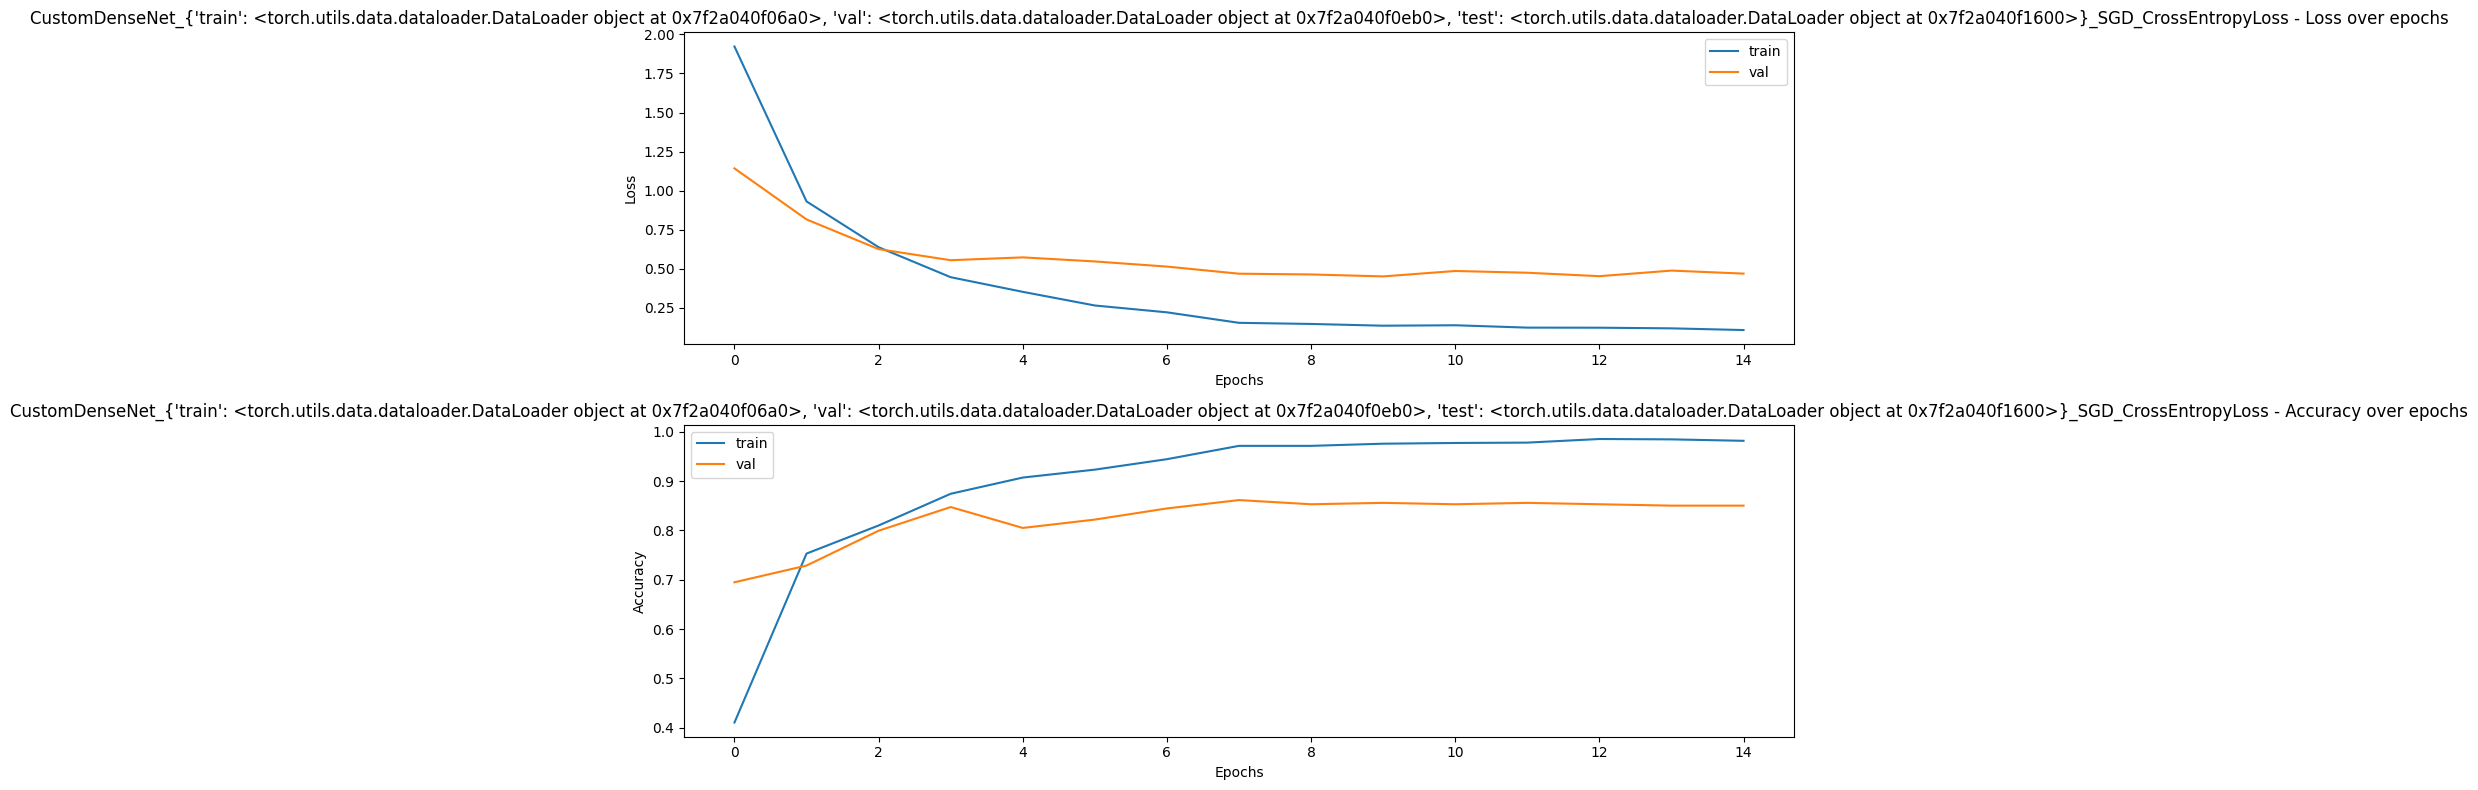


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4360 Acc: 0.4558
val Loss: 0.7617 Acc: 0.6638

Epoch 1/14
----------
train Loss: 0.5563 Acc: 0.7363
val Loss: 0.5309 Acc: 0.7429

Epoch 2/14
----------
train Loss: 0.3396 Acc: 0.8210
val Loss: 0.4696 Acc: 0.7768

Epoch 3/14
----------
train Loss: 0.2117 Acc: 0.8824
val Loss: 0.4200 Acc: 0.7910

Epoch 4/14
----------
train Loss: 0.1535 Acc: 0.9138
val Loss: 0.4018 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.1145 Acc: 0.9459
val Loss: 0.4198 Acc: 0.8136

Epoch 6/14
----------
train Loss: 0.0859 Acc: 0.9576
val Loss: 0.3596 Acc: 0.8164

Epoch 7/14
----------
train Loss: 0.0639 Acc: 0.9722
val Loss: 0.3576 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.0535 Acc: 0.9788
val Loss: 

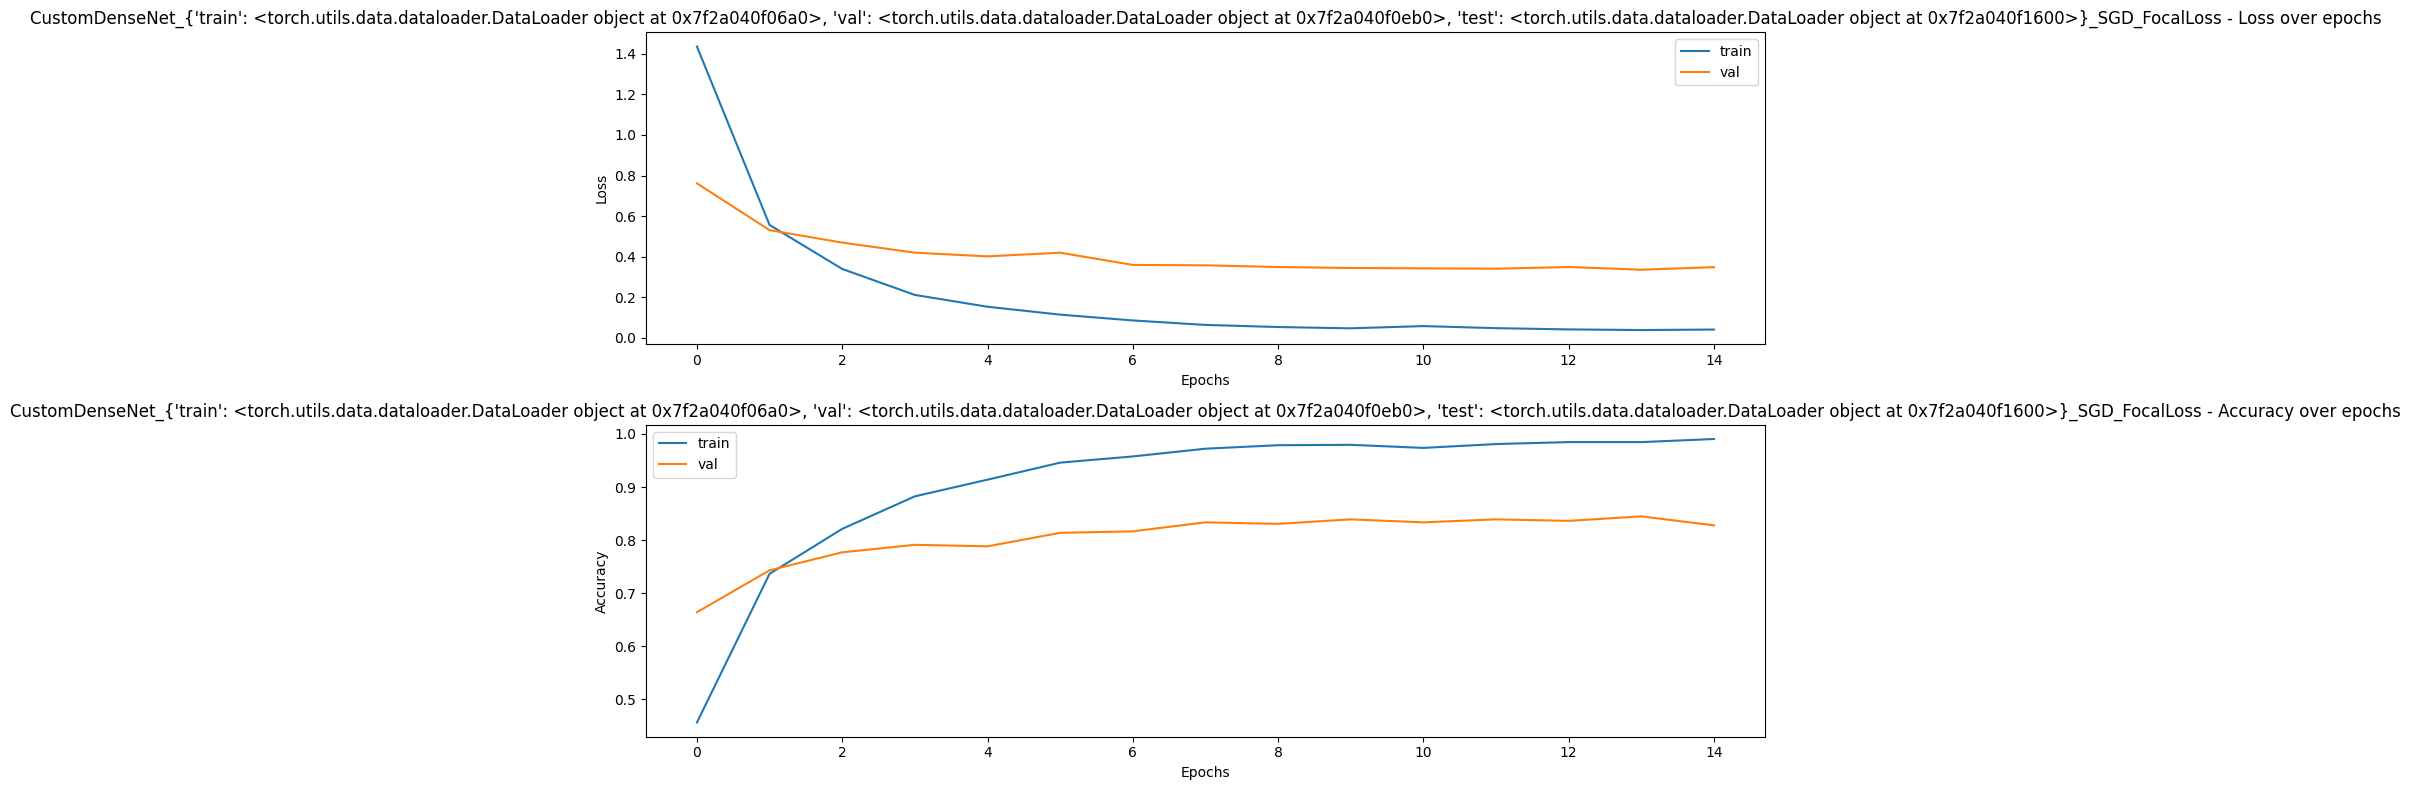


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.4844 Acc: 0.5318
val Loss: 1.7113 Acc: 0.5480

Epoch 1/14
----------
train Loss: 0.9368 Acc: 0.7005
val Loss: 1.4323 Acc: 0.5763

Epoch 2/14
----------
train Loss: 0.7029 Acc: 0.7765
val Loss: 0.7987 Acc: 0.7345

Epoch 3/14
----------
train Loss: 0.6142 Acc: 0.7991
val Loss: 0.7235 Acc: 0.7797

Epoch 4/14
----------
train Loss: 0.4958 Acc: 0.8371
val Loss: 1.4348 Acc: 0.5791

Epoch 5/14
----------
train Loss: 0.3979 Acc: 0.8692
val Loss: 1.0734 Acc: 0.6836

Epoch 6/14
----------
train Loss: 0.3416 Acc: 0.8875
val Loss: 0.8967 Acc: 0.7712

Epoch 7/14
----------
train Loss: 0.1862 Acc: 0.9481
val Loss: 0.5212 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.1283 Acc: 0.9657
va

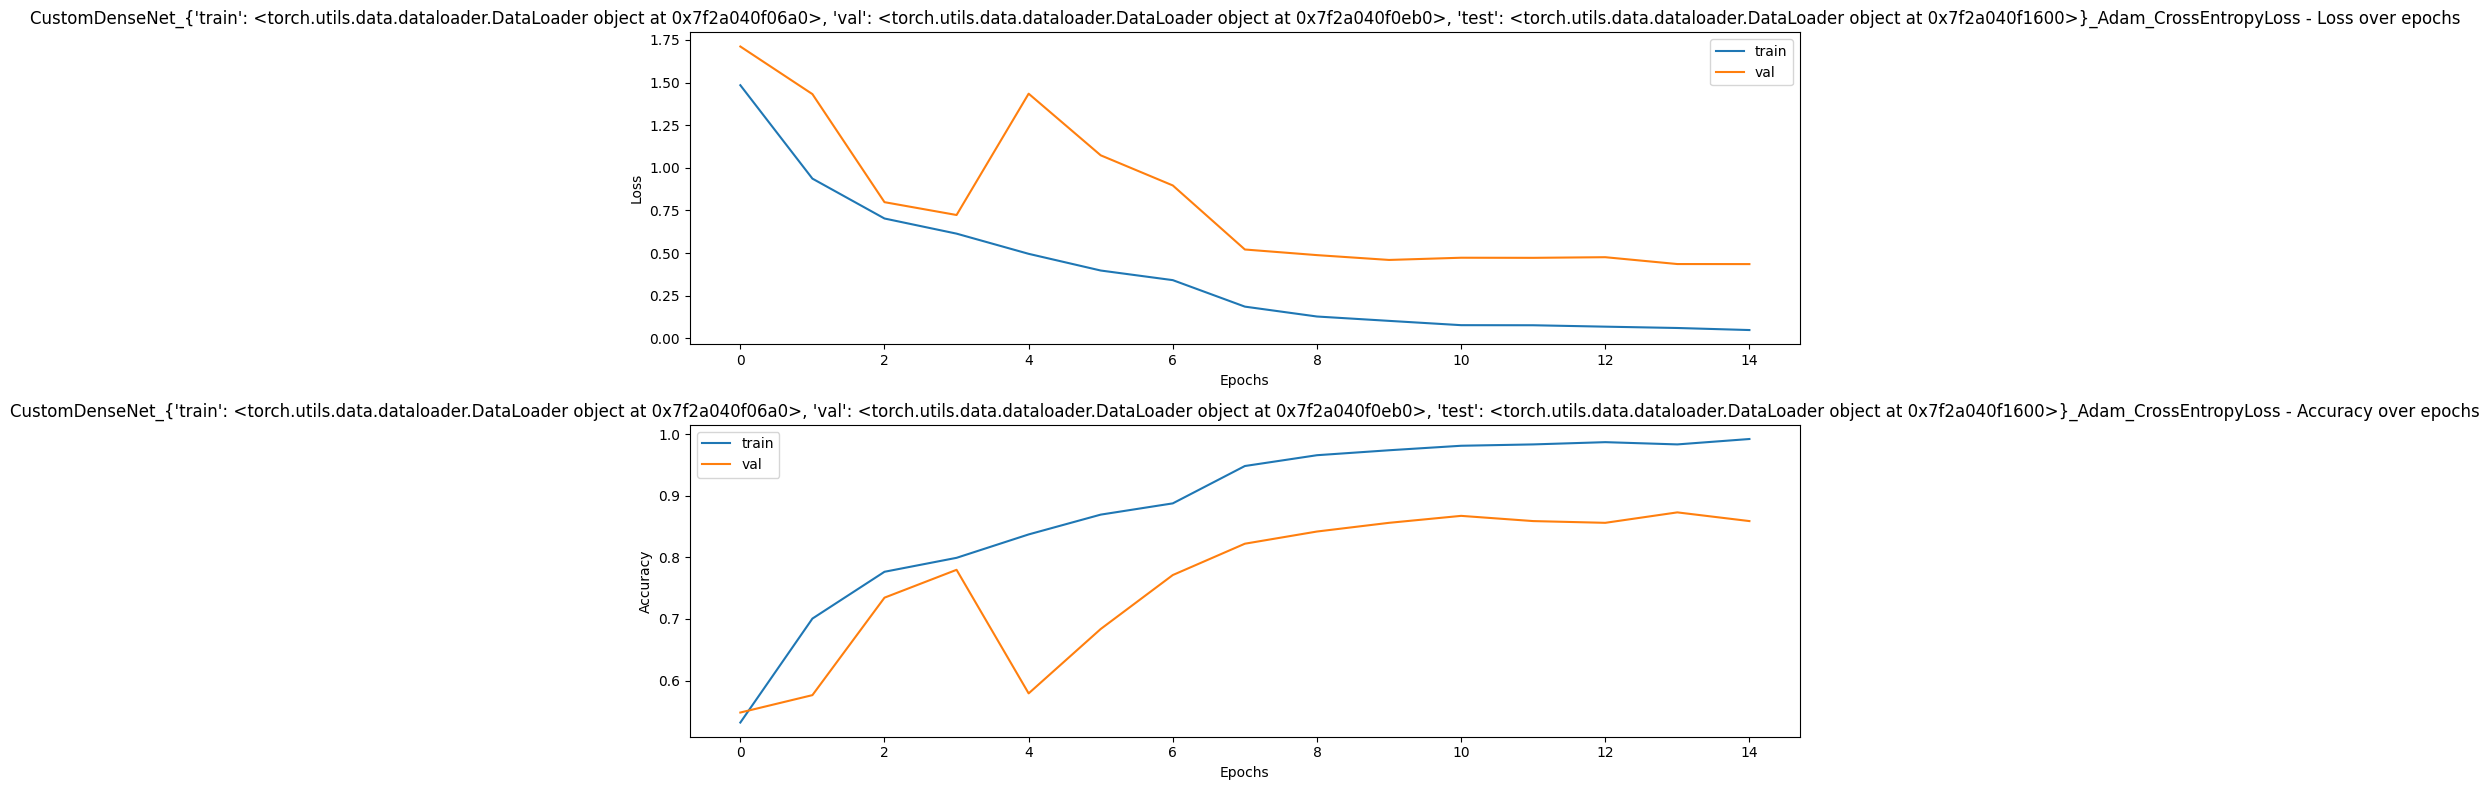


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f06a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f0eb0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2a040f1600>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0083 Acc: 0.5544
val Loss: 0.9258 Acc: 0.5650

Epoch 1/14
----------
train Loss: 0.5898 Acc: 0.6969
val Loss: 0.7580 Acc: 0.5876

Epoch 2/14
----------
train Loss: 0.4546 Acc: 0.7443
val Loss: 0.9777 Acc: 0.5706

Epoch 3/14
----------
train Loss: 0.3326 Acc: 0.7918
val Loss: 0.5993 Acc: 0.7203

Epoch 4/14
----------
train Loss: 0.2711 Acc: 0.8305
val Loss: 0.4614 Acc: 0.7994

Epoch 5/14
----------
train Loss: 0.2607 Acc: 0.8232
val Loss: 1.0478 Acc: 0.6328

Epoch 6/14
----------
train Loss: 0.1903 Acc: 0.8795
val Loss: 0.7017 Acc: 0.7571

Epoch 7/14
----------
train Loss: 0.1071 Acc: 0.9189
val Loss: 0.3157 Acc: 0.8531

Epoch 8/14
----------
train Loss: 0.0441 Acc: 0.9664
val Loss:

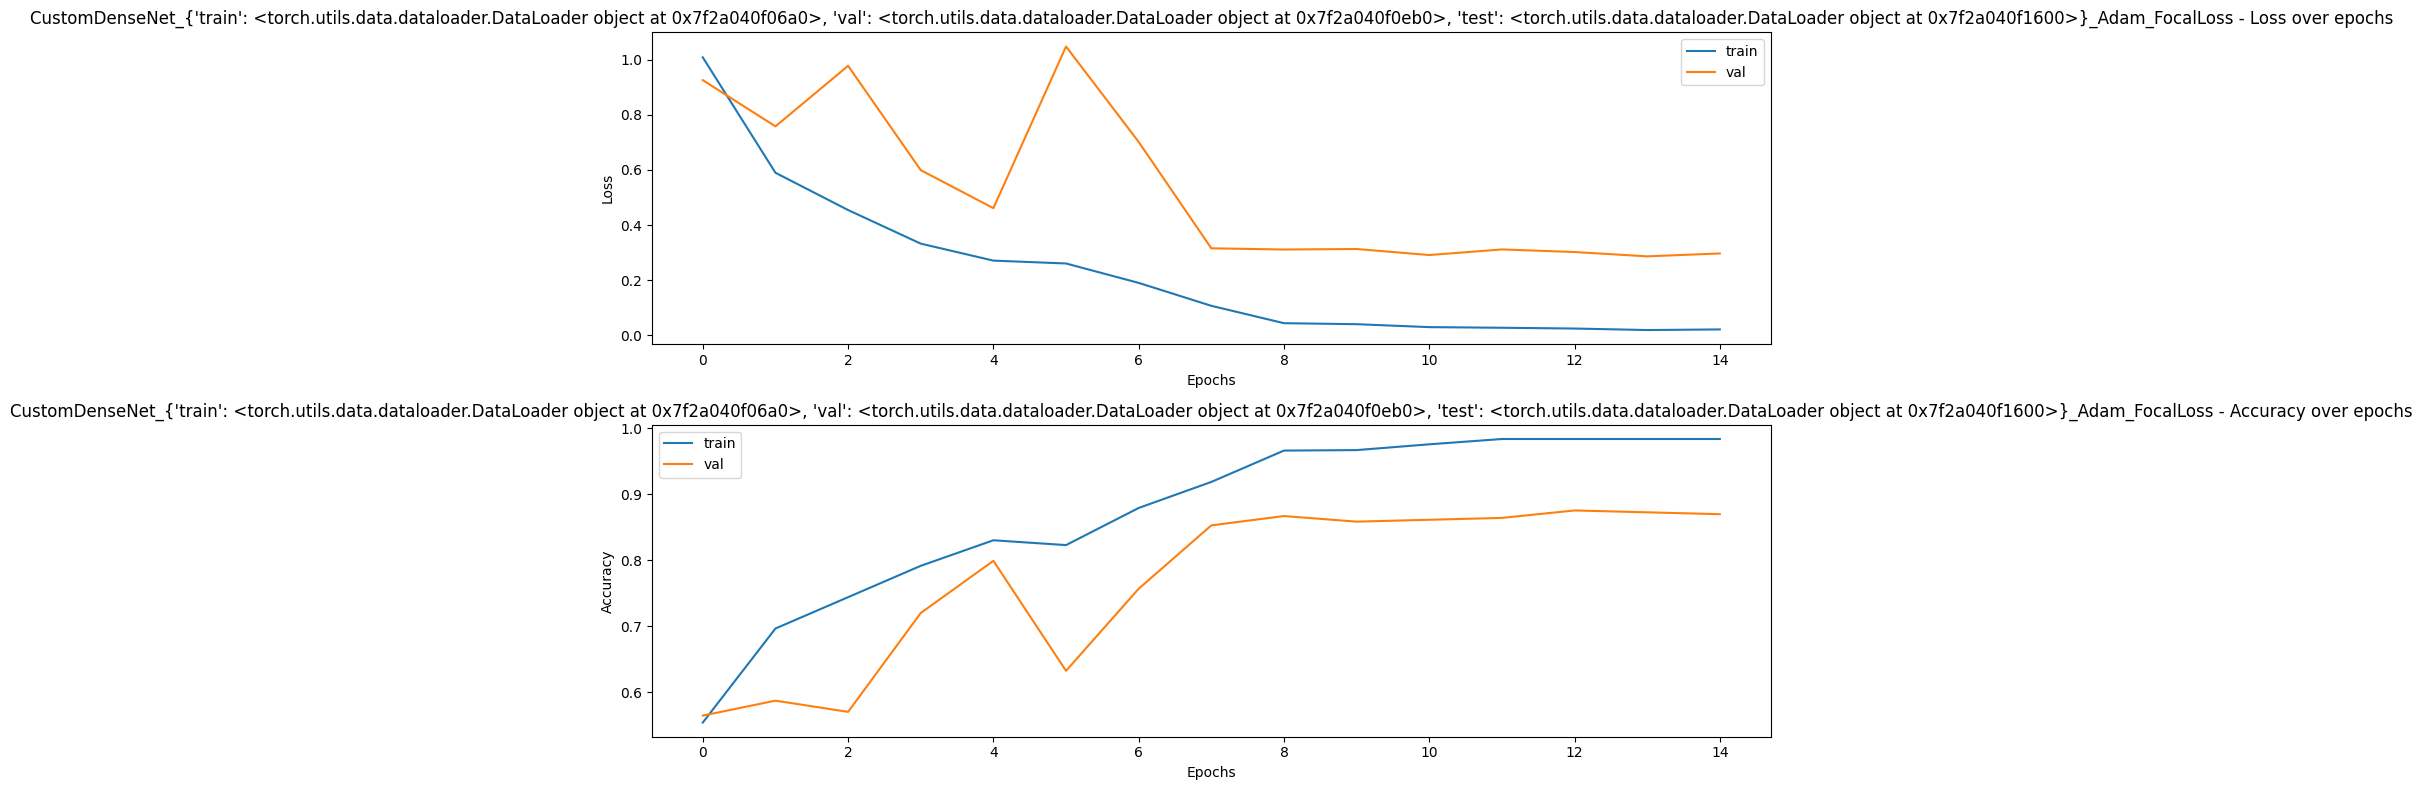

In [10]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loaders_dict[loader]}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loaders_dict[loader]}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_accuracy = best_val_accuracy
               

In [11]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           2       0.90      0.92      0.91        49
           6       0.88      1.00      0.93        14
           7       0.95      1.00      0.97        18
           8       0.97      0.91      0.94        35
           9       0.92      0.97      0.94        34
          11       1.00      0.95      0.97        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.95      0.95      0.95        19
          16       0.50      0.75      0.60        20
          17       1.00      0.94      0.97        17
          18       1.00      0.91      0.95        22
          19       1.00      0.95      0.97        19
          23       0.60      0.47      0.53        19
          25       0.85   

RuntimeError: ignored

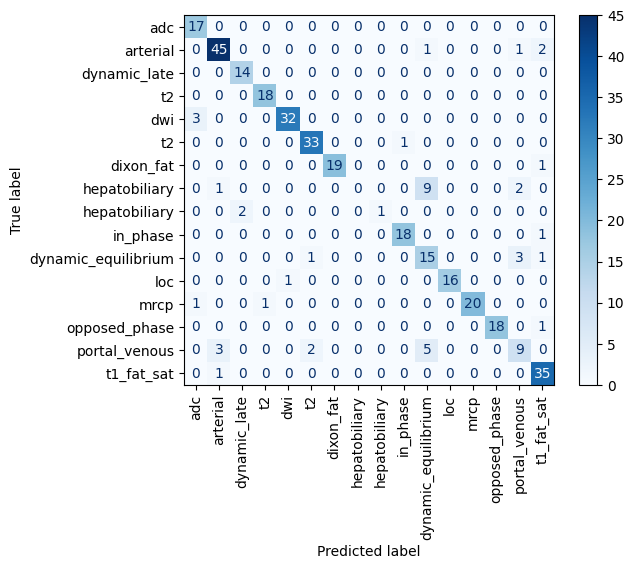

<Figure size 2500x2500 with 0 Axes>

In [12]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/model0529a.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [13]:
torch.save(trained_model.state_dict(), '/content/model0529a.pth')


In [15]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
    

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader = DataLoader(train_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = DataLoader(test_imgdata, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes = {'train': len(train_imgdata), 'val': len(val_imgdata)}

    return train_loader, val_loader, test_loader, dataset_sizes




deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}




train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.bias', 'cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [66]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [67]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [ ]:
deit_model = deit_model.to(device)
deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


Epoch 0/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 1/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 2/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 3/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 4/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 5/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 6/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 7/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 8/24
----------
train Loss: 7.0362 Acc: 0.0000
val Loss: 7.0482 Acc: 0.0000

Epoch 9/24
----------


In [61]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained DeiT model and adjust the classifier for your number of classes
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
num_classes = len(classes) # classes is your list of classes
deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
deit_model.to(device)

# Define your loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

num_epochs = 20

# Start training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_deit, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = deit_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.bias', 'cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [62]:
running_loss

60.25002270936966